In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

# Directory to save all results
SAVE_DIR = "figures"
os.makedirs(SAVE_DIR, exist_ok=True)

# Set a pastel color palette
pastel_palette = sns.color_palette("pastel")
ucsd_palette = sns.color_palette(
    [
        "#FFCD00",
        "#00629B",
        "#182B49",
        "#C69214",
        "#00C6D7",
        "#D462AD",
        "#F5F0E6",
        "#F3E500",
        "#FC8900",
        "#6E963B",
    ]
)
ucsd_accent_palette = sns.color_palette(["#00C6D7", "#D462AD", "#FC8900"])
sns.set_palette(ucsd_palette)

# Data processing


In [5]:
1e3

1000.0

In [2]:
df = pd.read_csv("verilog/merged_data.csv")
df = df.rename(columns={df.columns[0]: "name"})


# Extract dtype from name
def extract_dtype(name):
    match = re.search(r"_([^_]+)$", name)
    if match:
        return match.group(1)
    return None


# Add dtype column
df["dtype"] = df["name"].apply(extract_dtype)

# Create a custom order for dtypes
dtype_order = ["fp8", "bf16", "fp32"]
df["dtype_order"] = pd.Categorical(df["dtype"], categories=dtype_order, ordered=True)


# Extract architecture type (combinational, pipelined, stage_X)
def extract_architecture(name):
    if "combinational" in name:
        return "combinational"
    elif "pipelined" in name:
        return "pipelined"
    elif "stage" in name:
        match = re.search(r"stage_(\d+)", name)
        if match:
            return f"stage_{match.group(1)}"
    return "other"


# Fix the multiplier names to correctly identify them as pipelined
mask = df["name"].str.startswith("multiplier") & ~df["name"].str.contains(
    "stage|combinational"
)
df.loc[mask, "name"] = df.loc[mask, "name"].str.replace(
    "multiplier", "multiplier_pipelined"
)

# Re-extract the architecture information based on the updated names
df["architecture"] = df["name"].apply(extract_architecture)

# Display the updated names to verify
print("Updated multiplier names:")
print(df[df["name"].str.contains("multiplier_pipelined")]["name"].unique())


# Extract operation type (adder, multiplier, lmul)
def extract_operation(name):
    if name.startswith("adder"):
        return "adder"
    elif name.startswith("multiplier"):
        return "multiplier"
    elif name.startswith("lmul"):
        return "lmul"
    return "other"


df["operation"] = df["name"].apply(extract_operation)

# Extract if it's a fast implementation
df["is_fast"] = df["name"].apply(lambda x: "fast" in x)

# Display the first few rows to verify our transformations
df.head(10)

Updated multiplier names:
['multiplier_pipelined_bf16' 'multiplier_pipelined_fast_bf16'
 'multiplier_pipelined_fast_fp32' 'multiplier_pipelined_fast_fp8'
 'multiplier_pipelined_fp32' 'multiplier_pipelined_fp8']


name      area     power  max_arrival_time dtype  \
0       adder_combinational_bf16  1032.880  0.001745              2.50  bf16   
1  adder_combinational_fast_bf16   927.542  0.001954              1.46  bf16   
2  adder_combinational_fast_fp32  2886.370  0.010806              2.16  fp32   
3   adder_combinational_fast_fp8   510.188  0.001988              1.20   fp8   
4       adder_combinational_fp32  3230.040  0.005949              3.62  fp32   
5        adder_combinational_fp8   466.032  0.001910              1.77   fp8   
6           adder_pipelined_bf16  1657.710  0.002664              0.96  bf16   
7      adder_pipelined_fast_bf16  1603.450  0.002455              0.74  bf16   
8      adder_pipelined_fast_fp32  3979.090  0.005237              1.28  fp32   
9       adder_pipelined_fast_fp8   883.652  0.001661              0.67   fp8   

  dtype_order   architecture operation  is_fast  
0        bf16  combinational     adder    False  
1        bf16  combinational     adder     True  
2        fp32  combinational     adder     True  
3         fp8  combinational     adder     True  
4        fp32  combinational     adder    False  
5         fp8  combinational     adder    False  
6        bf16      pipelined     adder    False  
7        bf16      pipelined     adder     True  
8        fp32      pipelined     adder     True  
9         fp8      pipelined     adder     True

In [3]:
df.to_csv("demo/data/component_data.csv", index=False)

In [ ]:
for col in ["operation", "architecture", "dtype", "is_fast"]:
    print(f"{col}: {df[col].unique()}")

operation: ['adder' 'lmul' 'multiplier']
architecture: ['combinational' 'pipelined' 'stage_2' 'stage_3' 'stage_4' 'stage_5']
dtype: ['bf16' 'fp32' 'fp8']
is_fast: [False  True]


name,area,power,max_arrival_time,dtype,dtype_order,architecture,operation,is_fast
adder_combinational_bf16,1032.88,0.00174519,2.5,bf16,bf16,combinational,adder,False
adder_combinational_fast_bf16,927.542,0.00195394,1.46,bf16,bf16,combinational,adder,True
adder_combinational_fast_fp32,2886.37,0.0108059,2.16,fp32,fp32,combinational,adder,True
adder_combinational_fast_fp8,510.188,0.00198759,1.2,fp8,fp8,combinational,adder,True
adder_combinational_fp32,3230.04,0.00594875,3.62,fp32,fp32,combinational,adder,False
adder_combinational_fp8,466.032,0.00190965,1.77,fp8,fp8,combinational,adder,False
adder_pipelined_bf16,1657.71,0.00266433,0.96,bf16,bf16,pipelined,adder,False
adder_pipelined_fast_bf16,1603.45,0.00245527,0.74,bf16,bf16,pipelined,adder,True
adder_pipelined_fast_fp32,3979.09,0.0052372,1.28,fp32,fp32,pipelined,adder,True
adder_pipelined_fast_fp8,883.652,0.00166099,0.67,fp8,fp8,pipelined,adder,True


In [11]:
print(df.head(10).to_csv(index=False))

name,area,power,max_arrival_time,dtype,dtype_order,architecture,operation,is_fast
adder_combinational_bf16,1032.88,0.00174519,2.5,bf16,bf16,combinational,adder,False
adder_combinational_fast_bf16,927.542,0.00195394,1.46,bf16,bf16,combinational,adder,True
adder_combinational_fast_fp32,2886.37,0.0108059,2.16,fp32,fp32,combinational,adder,True
adder_combinational_fast_fp8,510.188,0.00198759,1.2,fp8,fp8,combinational,adder,True
adder_combinational_fp32,3230.04,0.00594875,3.62,fp32,fp32,combinational,adder,False
adder_combinational_fp8,466.032,0.00190965,1.77,fp8,fp8,combinational,adder,False
adder_pipelined_bf16,1657.71,0.00266433,0.96,bf16,bf16,pipelined,adder,False
adder_pipelined_fast_bf16,1603.45,0.00245527,0.74,bf16,bf16,pipelined,adder,True
adder_pipelined_fast_fp32,3979.09,0.0052372,1.28,fp32,fp32,pipelined,adder,True
adder_pipelined_fast_fp8,883.652,0.00166099,0.67,fp8,fp8,pipelined,adder,True



# General Visualizations


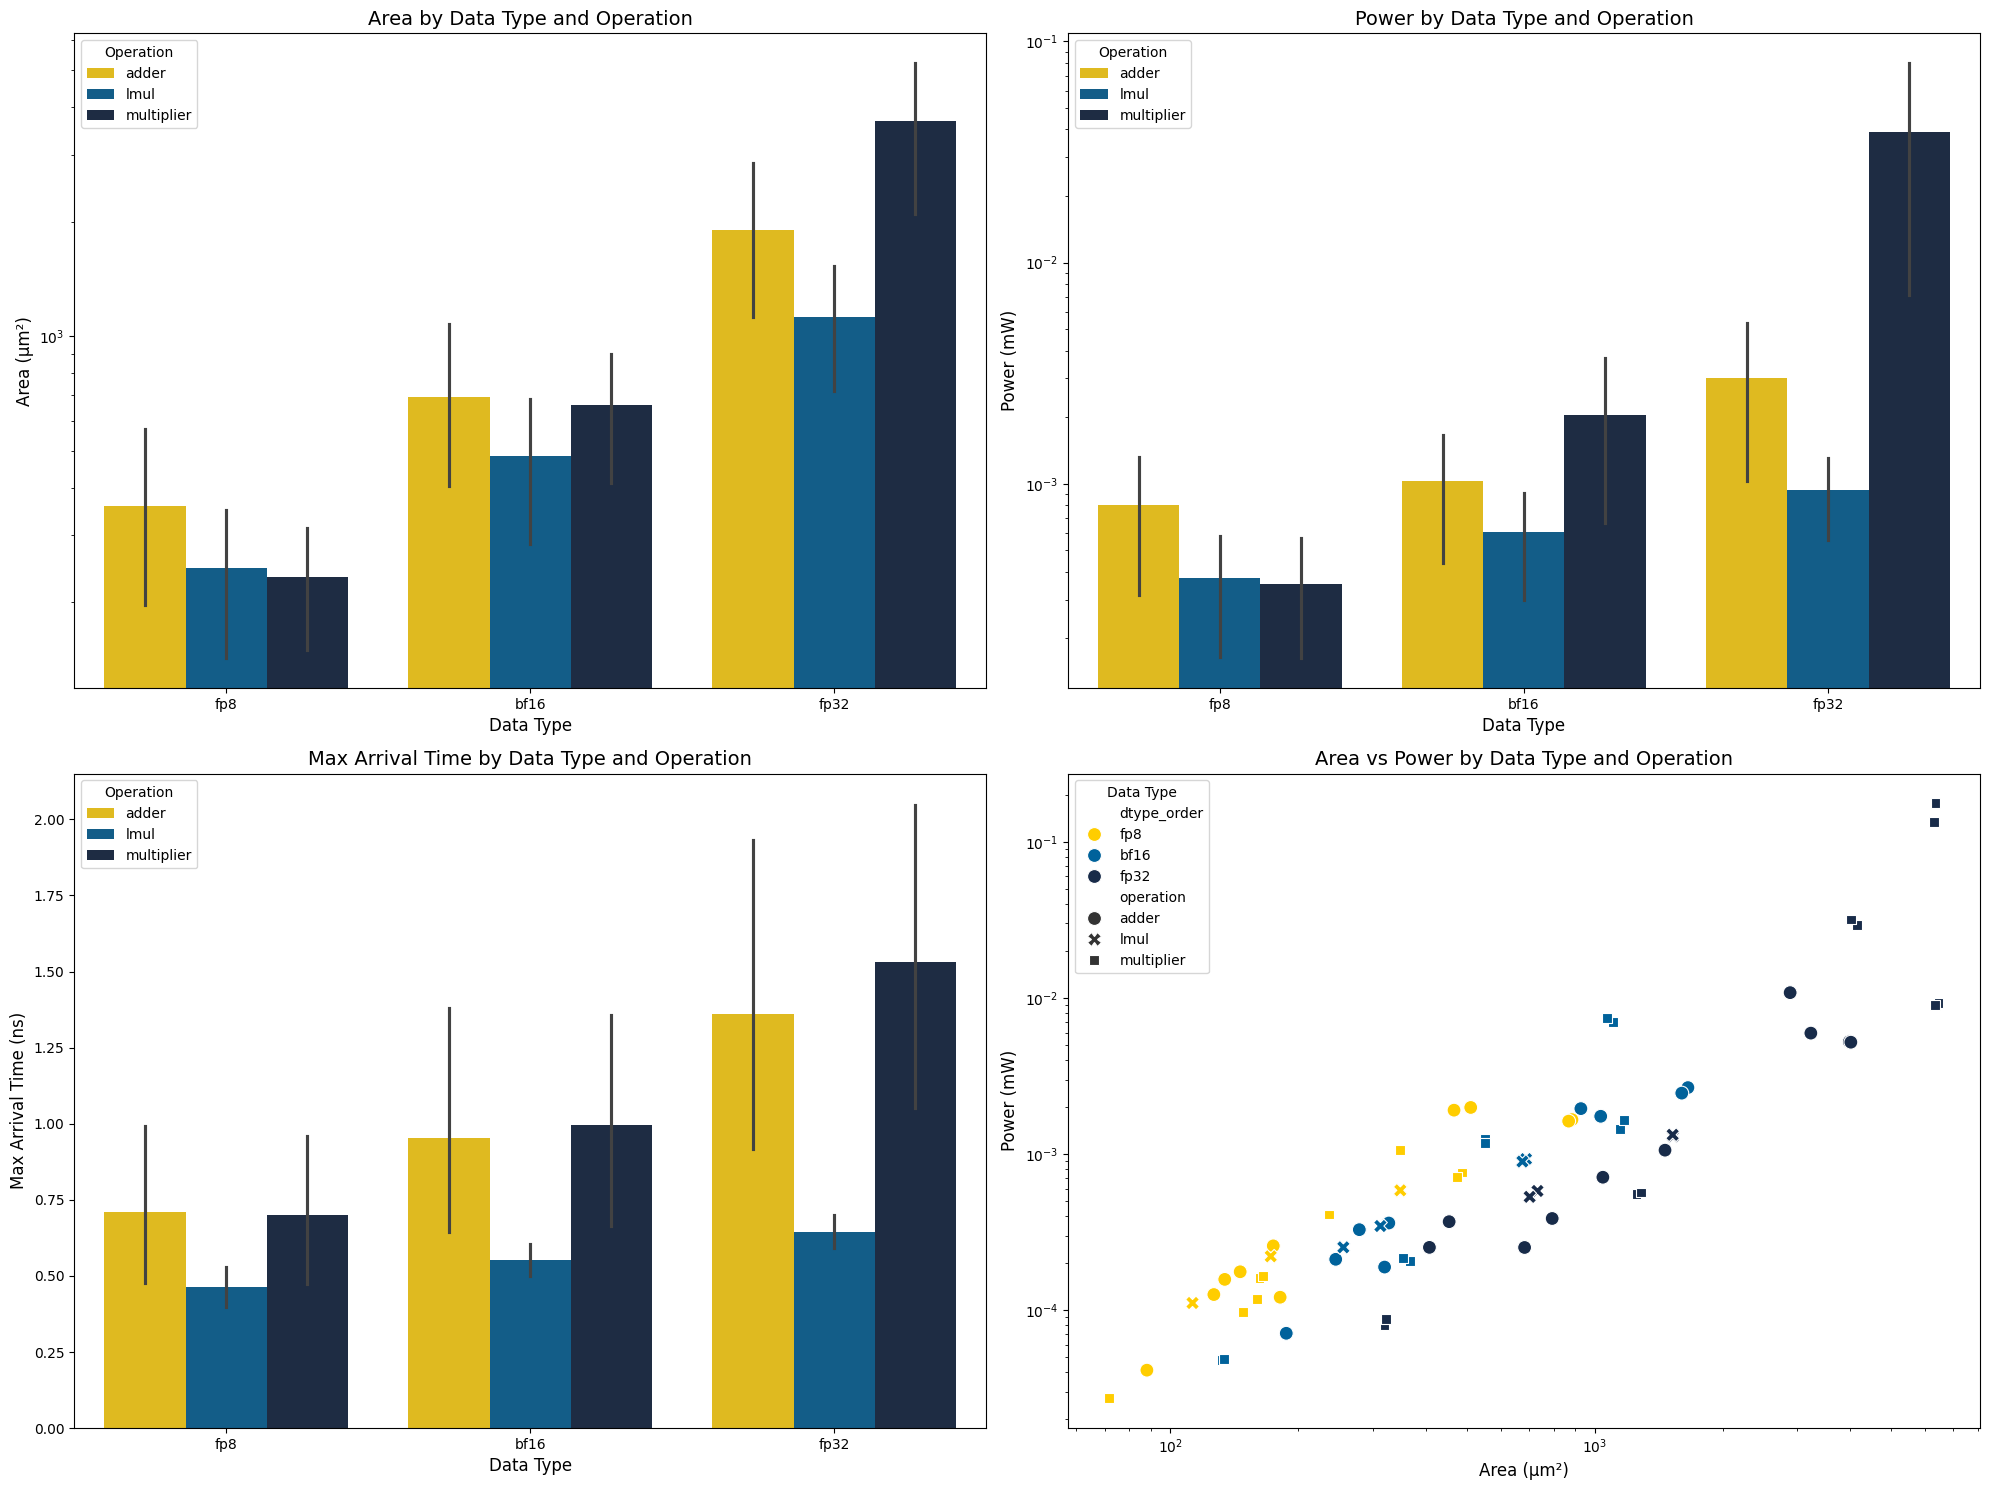

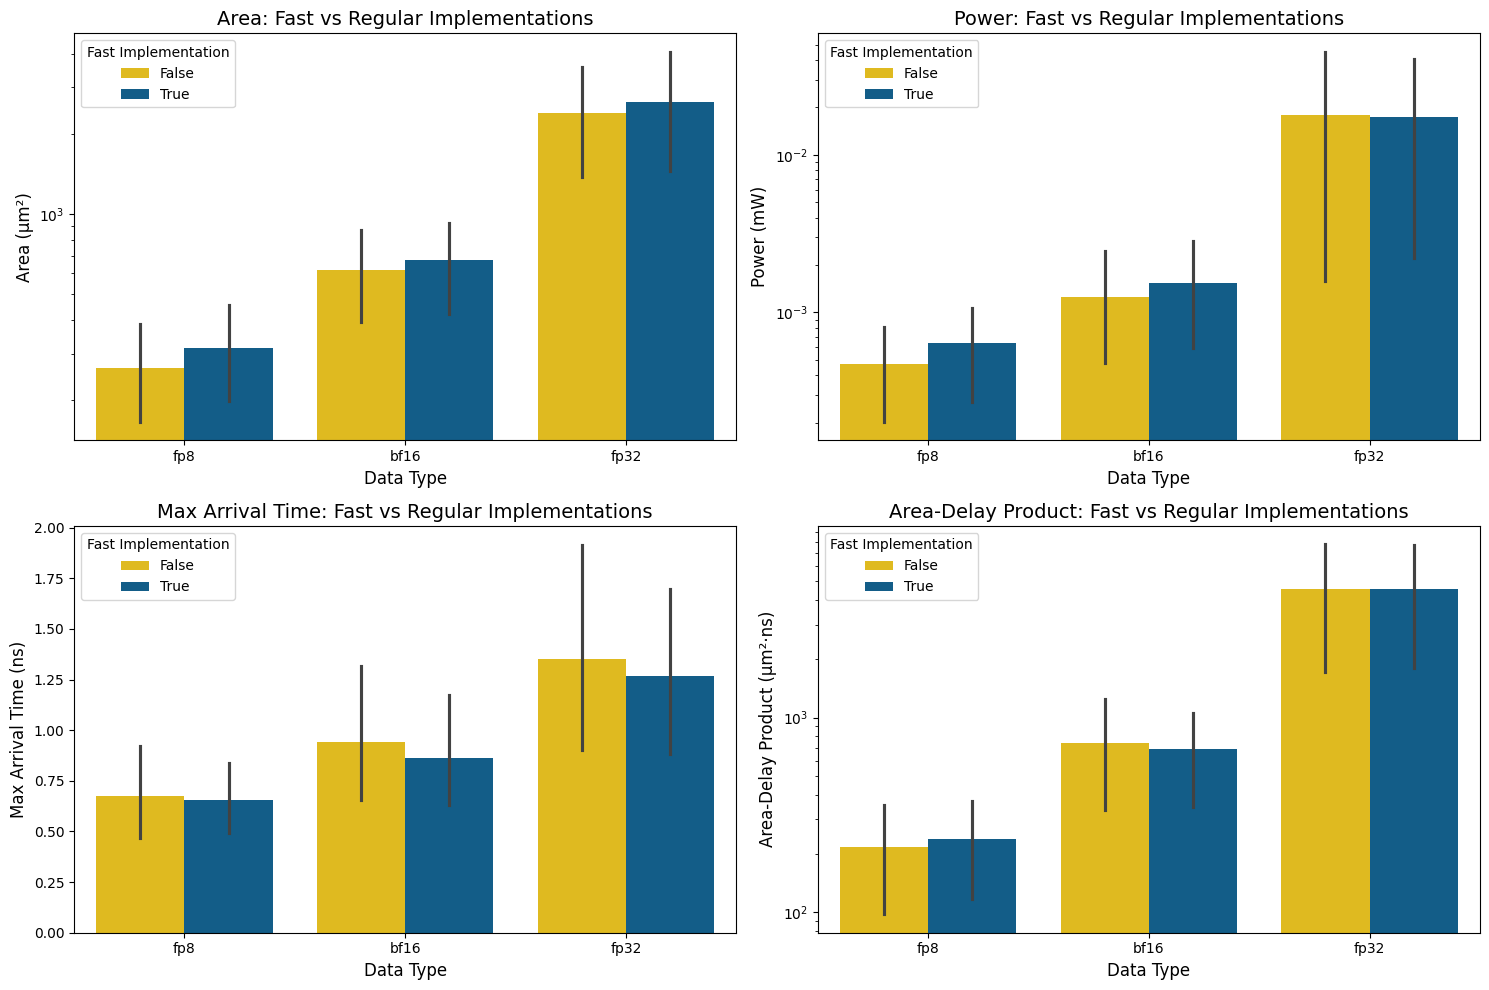

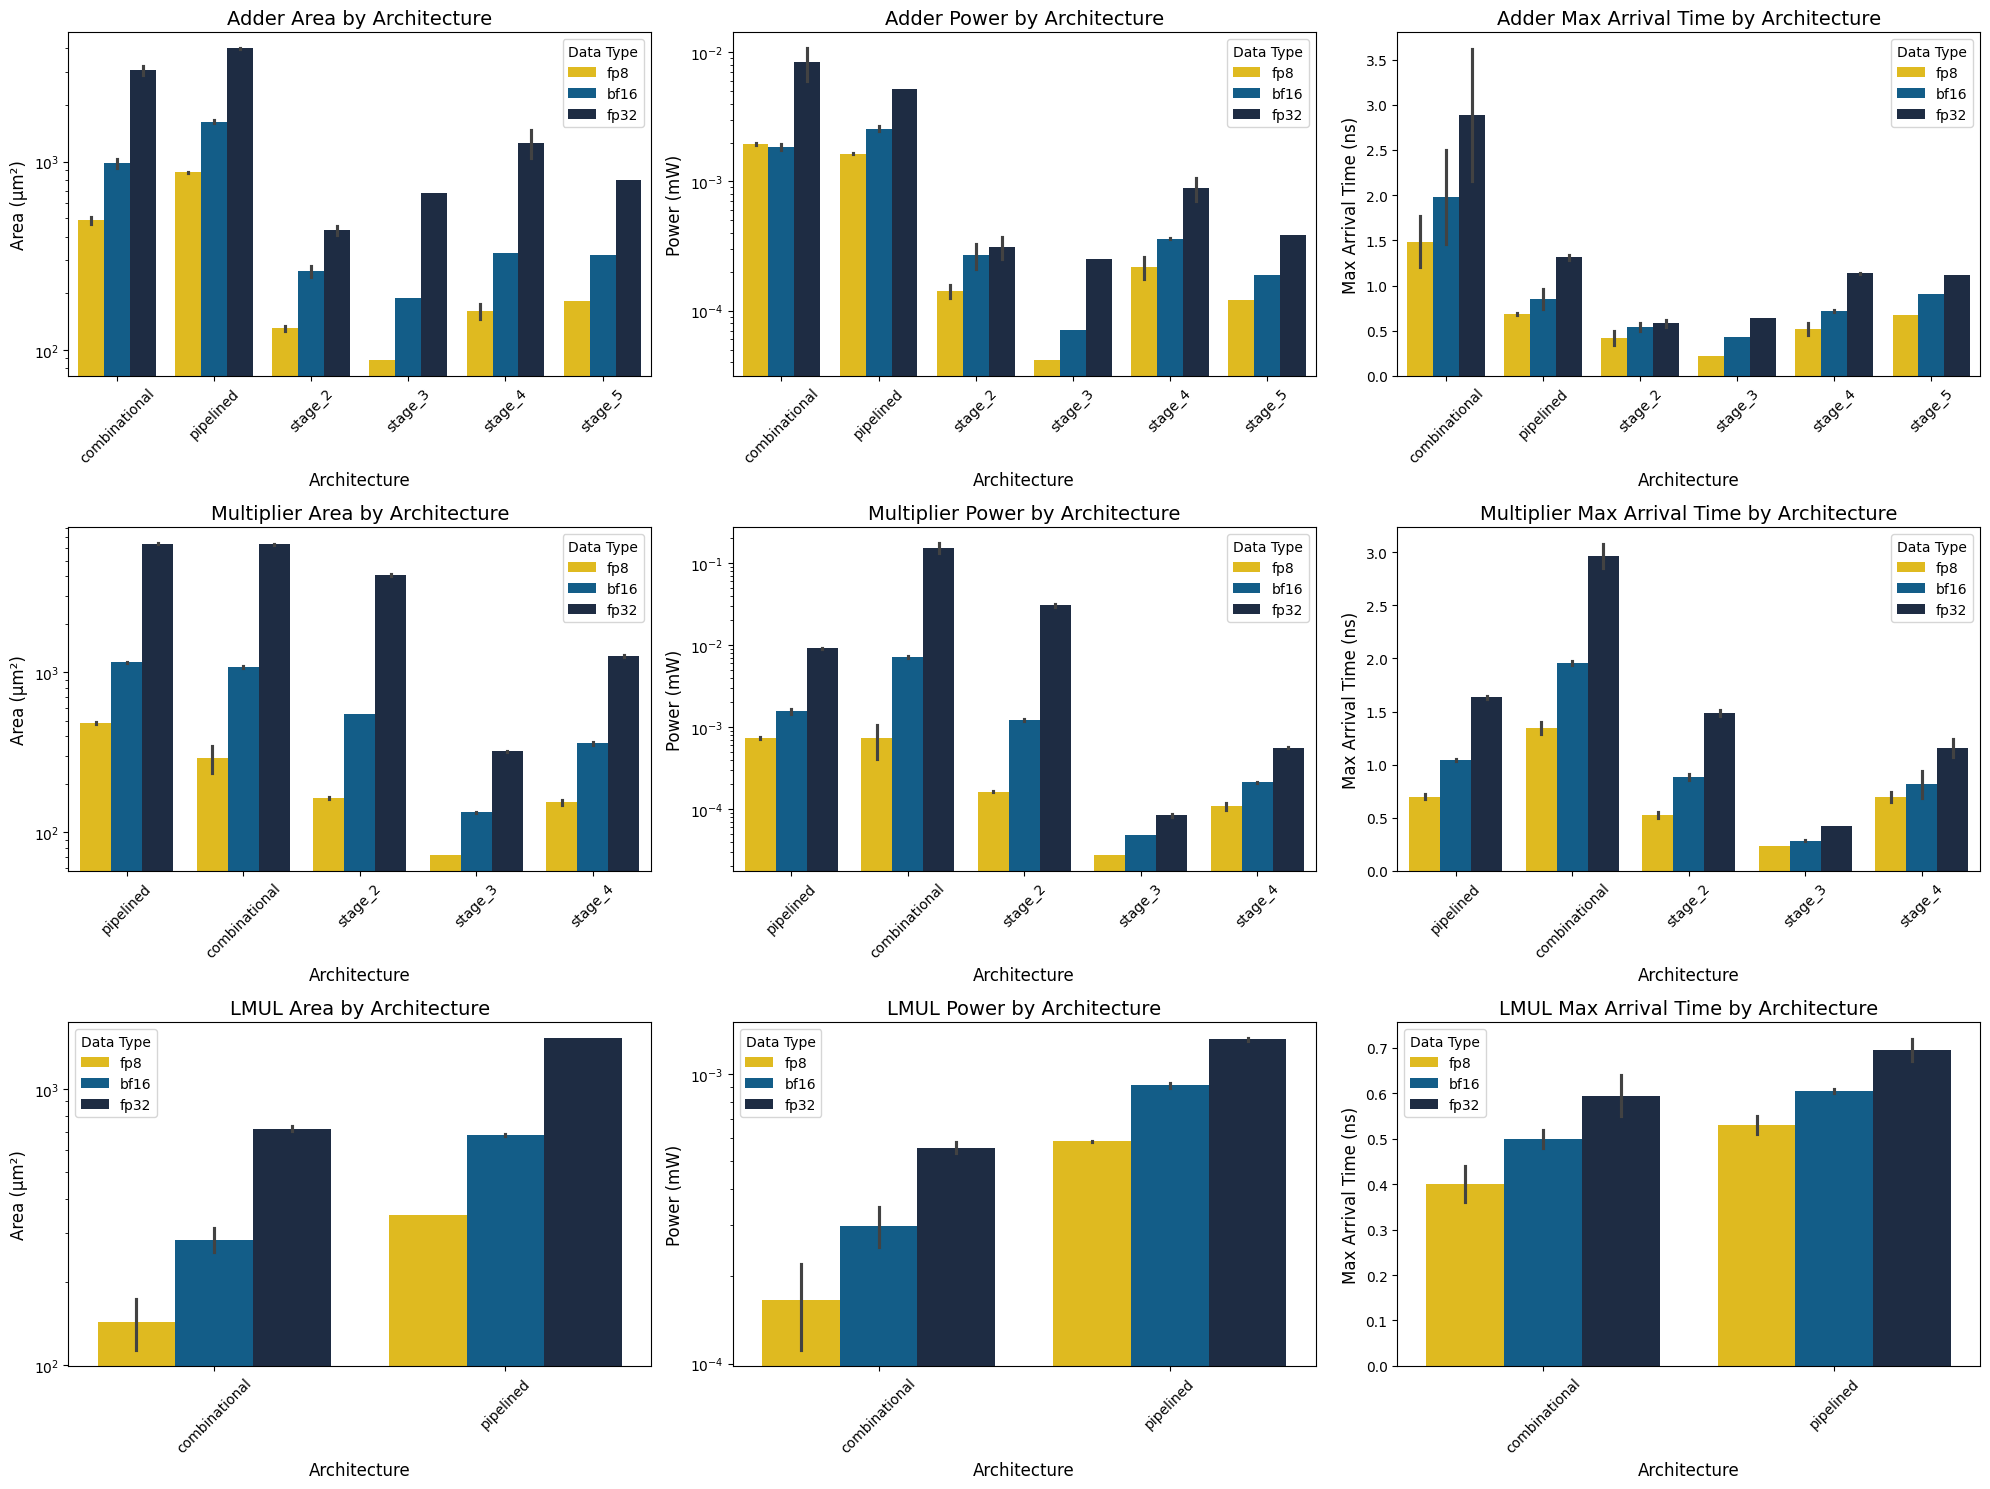

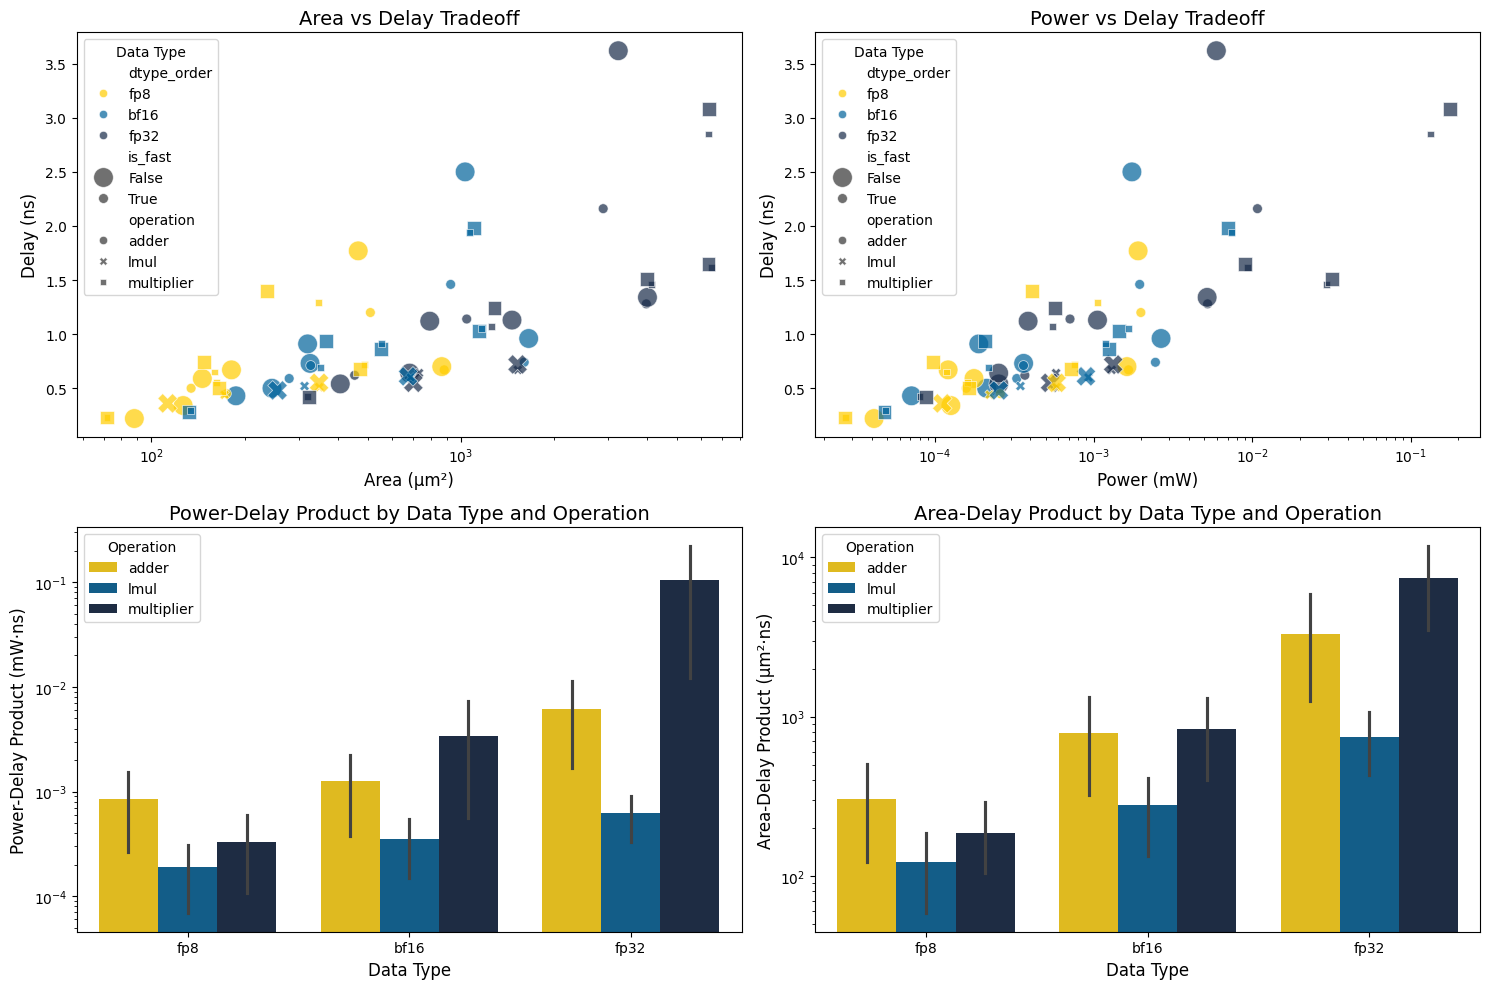


Best Designs by Metric:
                     Metric                       Design         Value
0             Smallest Area  multiplier_stage_3_fast_fp8     71.82 μm²
1              Lowest Power  multiplier_stage_3_fast_fp8       0.00 mW
2            Shortest Delay            adder_stage_3_fp8       0.22 ns
3   Best Area-Delay Product  multiplier_stage_3_fast_fp8  16.52 μm²·ns
4  Best Power-Delay Product  multiplier_stage_3_fast_fp8    0.00 mW·ns


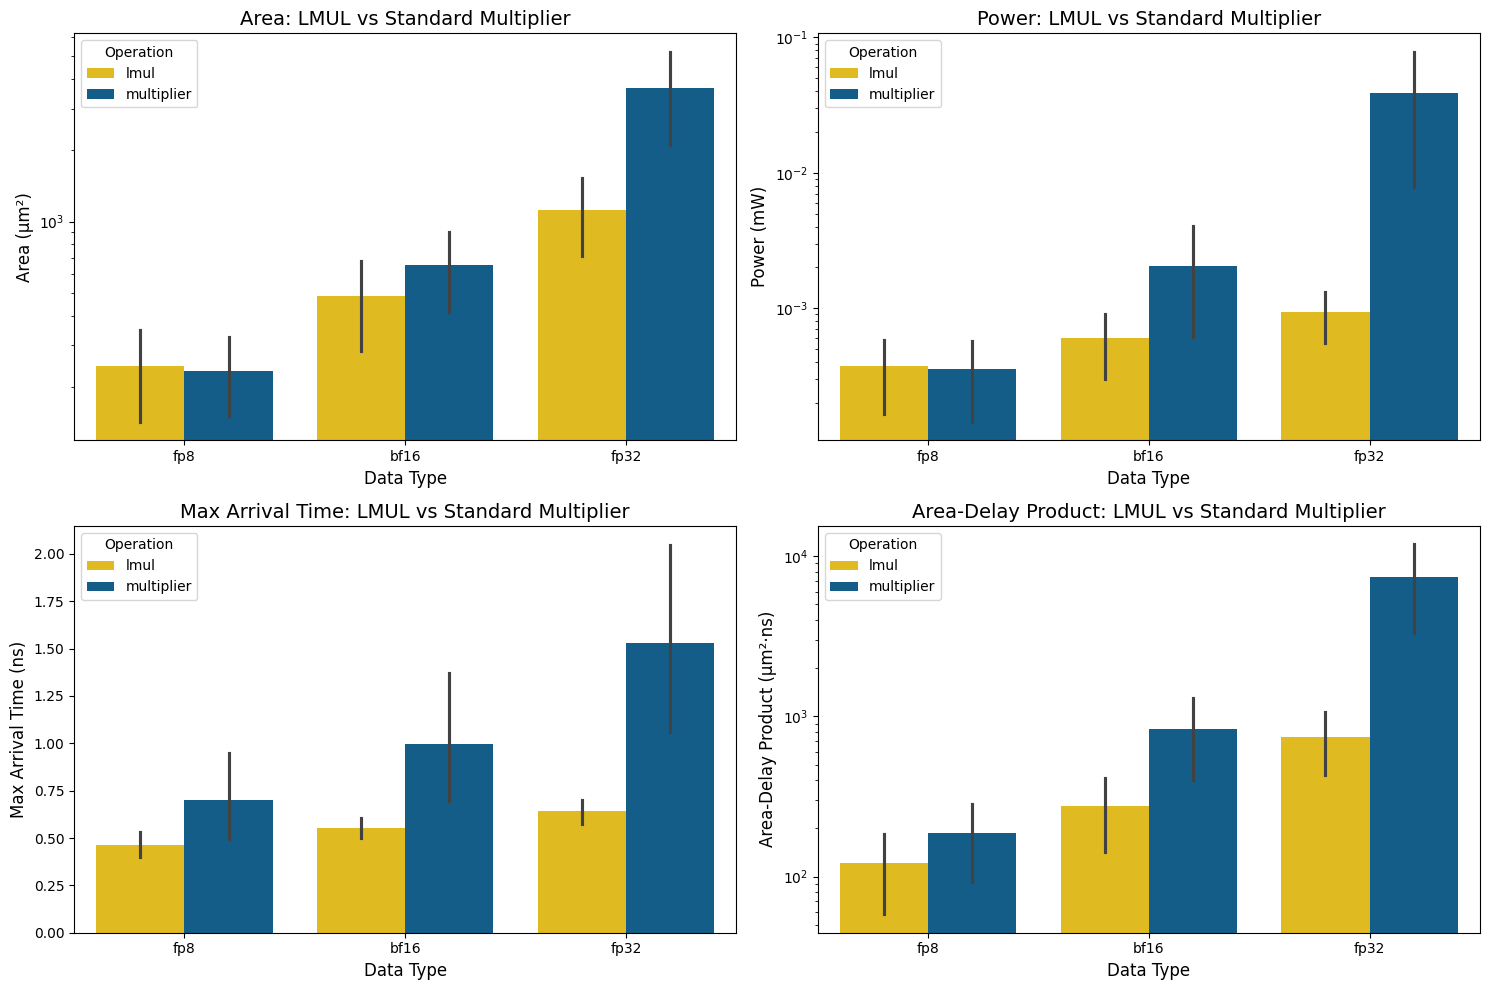

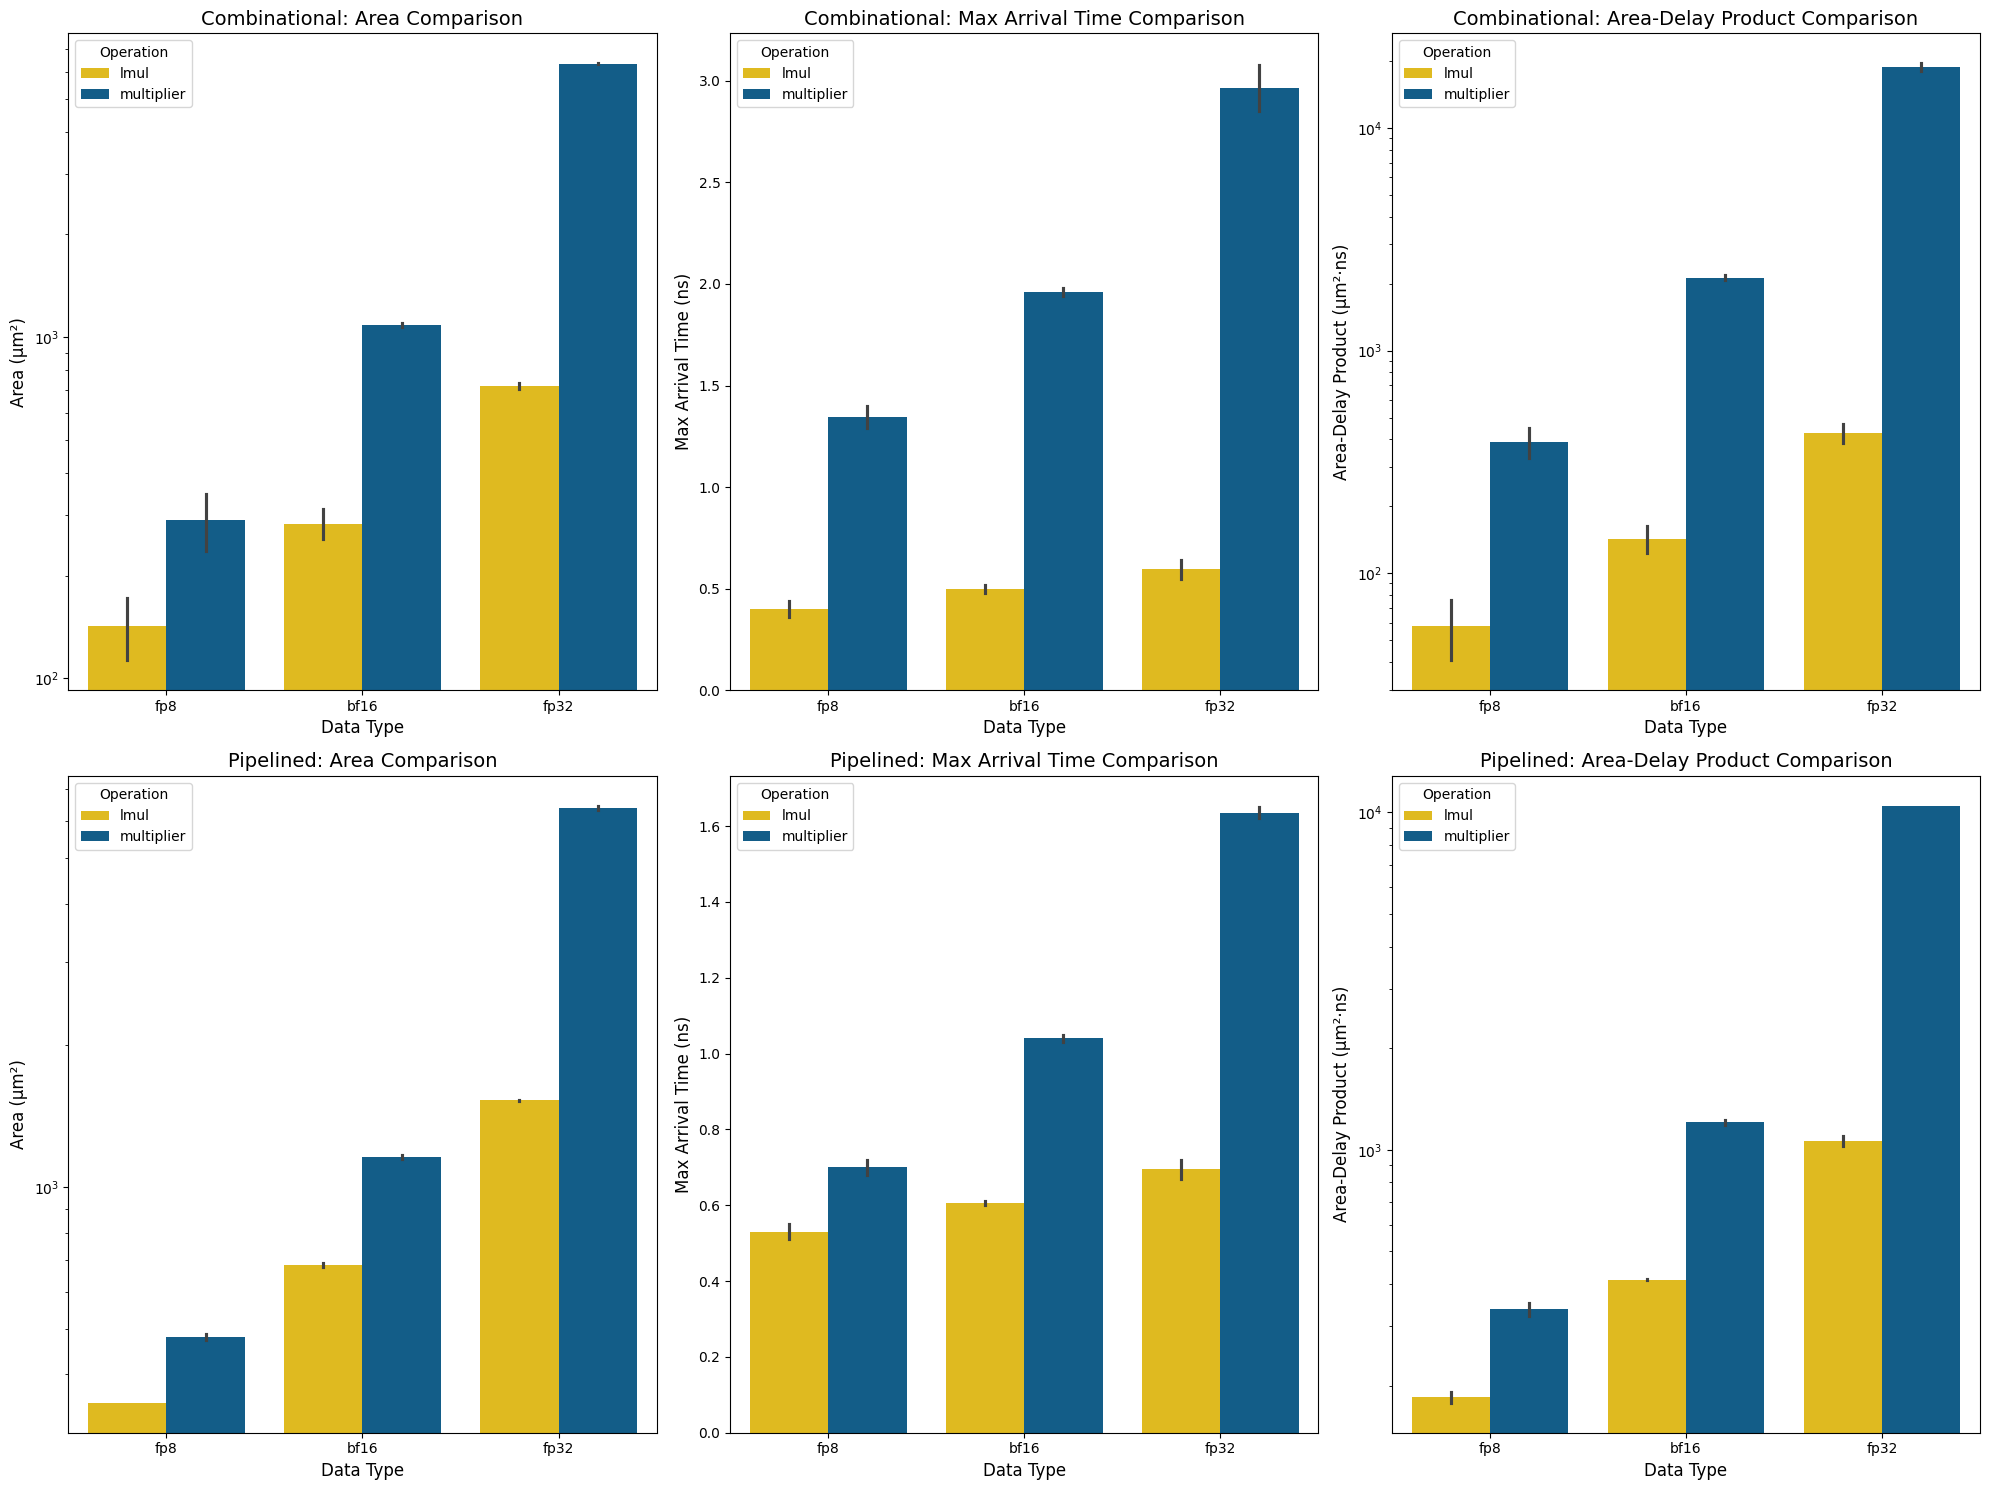


Average Improvement of LMUL over Standard Multiplier:
             Area Improvement (%)  Power Improvement (%)  \
dtype_order                                                
fp8                     -5.630579              -5.988850   
bf16                    26.569847              70.553833   
fp32                    69.481512              97.604657   

             Delay Improvement (%)  ADP Improvement (%)  PDP Improvement (%)  
dtype_order                                                                   
fp8                      33.476395            35.075351            42.742681  
bf16                     44.583751            66.580735            89.729253  
fp32                     57.898172            89.905281            99.404166  


/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3694059187.py:429: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mult_lmul_df.groupby(["dtype_order", "operation"])


<Figure size 1200x800 with 0 Axes>

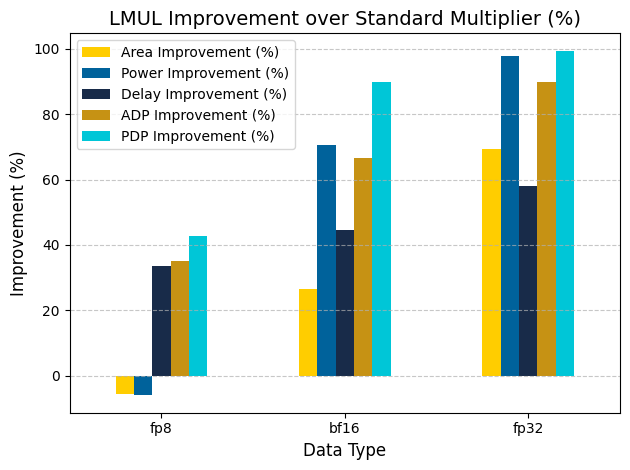

In [54]:
# Create a figure with multiple subplots for visualizations
plt.figure(figsize=(20, 15))

# 1. Area comparison by dtype and operation
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=df)
plt.title("Area by Data Type and Operation", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")  # Log scale for better visualization if values vary widely
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Power comparison by dtype and operation
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="operation", data=df)
plt.title("Power by Data Type and Operation", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")  # Log scale for better visualization if values vary widely
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. Max arrival time comparison by dtype and operation
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="operation", data=df)
plt.title("Max Arrival Time by Data Type and Operation", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area vs Power scatter plot, colored by dtype
plt.subplot(2, 2, 4)
sns.scatterplot(
    x="area", y="power", hue="dtype_order", style="operation", s=100, data=df
)
plt.title("Area vs Power by Data Type and Operation", fontsize=14)
plt.xlabel("Area (μm²)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.legend(title="Data Type")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "hardware_metrics_overview.png"), dpi=300)
plt.show()

# Create a figure to compare fast vs regular implementations
plt.figure(figsize=(15, 10))

# 1. Area comparison: fast vs regular
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="is_fast", data=df)
plt.title("Area: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 2. Power comparison: fast vs regular
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="is_fast", data=df)
plt.title("Power: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 3. Max arrival time comparison: fast vs regular
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="is_fast", data=df)
plt.title("Max Arrival Time: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 4. Area-Delay Product (ADP) comparison
df["adp"] = df["area"] * df["max_arrival_time"]
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="is_fast", data=df)
plt.title("Area-Delay Product: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "fast_vs_regular_comparison.png"), dpi=300)
plt.show()

# Create a figure to compare different architectures for each operation
plt.figure(figsize=(20, 15))

# Filter for adders only
adders_df = df[df["operation"] == "adder"]

# 1. Area comparison by architecture for adders
plt.subplot(3, 3, 1)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=adders_df)
plt.title("Adder Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 2. Power comparison by architecture for adders
plt.subplot(3, 3, 2)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=adders_df)
plt.title("Adder Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 3. Max arrival time comparison by architecture for adders
plt.subplot(3, 3, 3)
sns.barplot(x="architecture", y="max_arrival_time", hue="dtype_order", data=adders_df)
plt.title("Adder Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# Filter for multipliers only
multipliers_df = df[df["operation"] == "multiplier"]

# 4. Area comparison by architecture for multipliers
plt.subplot(3, 3, 4)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=multipliers_df)
plt.title("Multiplier Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 5. Power comparison by architecture for multipliers
plt.subplot(3, 3, 5)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=multipliers_df)
plt.title("Multiplier Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 6. Max arrival time comparison by architecture for multipliers
plt.subplot(3, 3, 6)
sns.barplot(
    x="architecture", y="max_arrival_time", hue="dtype_order", data=multipliers_df
)
plt.title("Multiplier Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# Filter for lmul only
lmul_df = df[df["operation"] == "lmul"]

# 7. Area comparison by architecture for lmul
plt.subplot(3, 3, 7)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=lmul_df)
plt.title("LMUL Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 8. Power comparison by architecture for lmul
plt.subplot(3, 3, 8)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=lmul_df)
plt.title("LMUL Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 9. Max arrival time comparison by architecture for lmul
plt.subplot(3, 3, 9)
sns.barplot(x="architecture", y="max_arrival_time", hue="dtype_order", data=lmul_df)
plt.title("LMUL Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "architecture_comparison_by_operation.png"), dpi=300)
plt.show()

# Create a figure to show the tradeoffs between area, power, and delay
plt.figure(figsize=(15, 10))

# 1. Area vs Delay scatter plot
plt.subplot(2, 2, 1)
sns.scatterplot(
    x="area",
    y="max_arrival_time",
    hue="dtype_order",
    style="operation",
    size="is_fast",
    sizes=(50, 200),
    alpha=0.7,
    data=df,
)
plt.title("Area vs Delay Tradeoff", fontsize=14)
plt.xlabel("Area (μm²)", fontsize=12)
plt.ylabel("Delay (ns)", fontsize=12)
plt.xscale("log")
plt.legend(title="Data Type")

# 2. Power vs Delay scatter plot
plt.subplot(2, 2, 2)
sns.scatterplot(
    x="power",
    y="max_arrival_time",
    hue="dtype_order",
    style="operation",
    size="is_fast",
    sizes=(50, 200),
    alpha=0.7,
    data=df,
)
plt.title("Power vs Delay Tradeoff", fontsize=14)
plt.xlabel("Power (mW)", fontsize=12)
plt.ylabel("Delay (ns)", fontsize=12)
plt.xscale("log")
plt.legend(title="Data Type")

# 3. Power-Delay Product (PDP)
df["pdp"] = df["power"] * df["max_arrival_time"]
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="pdp", hue="operation", data=df)
plt.title("Power-Delay Product by Data Type and Operation", fontsize=14)
plt.ylabel("Power-Delay Product (mW·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area-Delay Product (ADP)
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=df)
plt.title("Area-Delay Product by Data Type and Operation", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "hardware_tradeoffs.png"), dpi=300)
plt.show()

# Create a table with the best designs for each metric
print("\nBest Designs by Metric:")
best_area = df.loc[df["area"].idxmin()]
best_power = df.loc[df["power"].idxmin()]
best_delay = df.loc[df["max_arrival_time"].idxmin()]
best_adp = df.loc[df["adp"].idxmin()]
best_pdp = df.loc[df["pdp"].idxmin()]

best_designs = pd.DataFrame(
    {
        "Metric": [
            "Smallest Area",
            "Lowest Power",
            "Shortest Delay",
            "Best Area-Delay Product",
            "Best Power-Delay Product",
        ],
        "Design": [
            best_area["name"],
            best_power["name"],
            best_delay["name"],
            best_adp["name"],
            best_pdp["name"],
        ],
        "Value": [
            f"{best_area['area']:.2f} μm²",
            f"{best_power['power']:.2f} mW",
            f"{best_delay['max_arrival_time']:.2f} ns",
            f"{best_adp['adp']:.2f} μm²·ns",
            f"{best_pdp['pdp']:.2f} mW·ns",
        ],
    }
)
print(best_designs)

# Compare LMUL vs standard multiplier implementations
plt.figure(figsize=(15, 10))

# Filter for multiplier and lmul operations
mult_lmul_df = df[(df["operation"] == "multiplier") | (df["operation"] == "lmul")]

# 1. Area comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=mult_lmul_df)
plt.title("Area: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Power comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="operation", data=mult_lmul_df)
plt.title("Power: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. Max arrival time comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="operation", data=mult_lmul_df)
plt.title("Max Arrival Time: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area-Delay Product comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=mult_lmul_df)
plt.title("Area-Delay Product: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_vs_standard_multiplier.png"), dpi=300)
plt.show()

# Further analyze LMUL vs standard multiplier by architecture type
plt.figure(figsize=(20, 15))

# Filter for combinational architectures
comb_mult_lmul_df = mult_lmul_df[mult_lmul_df["architecture"] == "combinational"]

# 1. Area comparison for combinational architectures
plt.subplot(2, 3, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=comb_mult_lmul_df)
plt.title("Combinational: Area Comparison", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Max arrival time comparison for combinational architectures
plt.subplot(2, 3, 2)
sns.barplot(
    x="dtype_order", y="max_arrival_time", hue="operation", data=comb_mult_lmul_df
)
plt.title("Combinational: Max Arrival Time Comparison", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. ADP comparison for combinational architectures
plt.subplot(2, 3, 3)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=comb_mult_lmul_df)
plt.title("Combinational: Area-Delay Product Comparison", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# Filter for pipelined architectures
pipe_mult_lmul_df = mult_lmul_df[mult_lmul_df["architecture"] == "pipelined"]

# 4. Area comparison for pipelined architectures
plt.subplot(2, 3, 4)
sns.barplot(x="dtype_order", y="area", hue="operation", data=pipe_mult_lmul_df)
plt.title("Pipelined: Area Comparison", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 5. Max arrival time comparison for pipelined architectures
plt.subplot(2, 3, 5)
sns.barplot(
    x="dtype_order", y="max_arrival_time", hue="operation", data=pipe_mult_lmul_df
)
plt.title("Pipelined: Max Arrival Time Comparison", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 6. ADP comparison for pipelined architectures
plt.subplot(2, 3, 6)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=pipe_mult_lmul_df)
plt.title("Pipelined: Area-Delay Product Comparison", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_vs_multiplier_by_architecture.png"), dpi=300)
plt.show()

# Calculate and display average improvement of LMUL over standard multiplier
print("\nAverage Improvement of LMUL over Standard Multiplier:")

# Group by dtype and operation
grouped = (
    mult_lmul_df.groupby(["dtype_order", "operation"])
    .agg(
        {
            "area": "mean",
            "power": "mean",
            "max_arrival_time": "mean",
            "adp": "mean",
            "pdp": "mean",
        }
    )
    .reset_index()
)

# Pivot to get multiplier and lmul side by side
pivot_area = grouped.pivot(index="dtype_order", columns="operation", values="area")
pivot_power = grouped.pivot(index="dtype_order", columns="operation", values="power")
pivot_delay = grouped.pivot(
    index="dtype_order", columns="operation", values="max_arrival_time"
)
pivot_adp = grouped.pivot(index="dtype_order", columns="operation", values="adp")
pivot_pdp = grouped.pivot(index="dtype_order", columns="operation", values="pdp")

# Calculate percentage improvement
area_improvement = (1 - pivot_area["lmul"] / pivot_area["multiplier"]) * 100
power_improvement = (1 - pivot_power["lmul"] / pivot_power["multiplier"]) * 100
delay_improvement = (1 - pivot_delay["lmul"] / pivot_delay["multiplier"]) * 100
adp_improvement = (1 - pivot_adp["lmul"] / pivot_adp["multiplier"]) * 100
pdp_improvement = (1 - pivot_pdp["lmul"] / pivot_pdp["multiplier"]) * 100

# Create a DataFrame with the improvements
improvements = pd.DataFrame(
    {
        "Area Improvement (%)": area_improvement,
        "Power Improvement (%)": power_improvement,
        "Delay Improvement (%)": delay_improvement,
        "ADP Improvement (%)": adp_improvement,
        "PDP Improvement (%)": pdp_improvement,
    }
)

print(improvements)

# Save the improvements to a CSV file
improvements.to_csv(os.path.join(SAVE_DIR, "lmul_vs_multiplier_improvements.csv"))

# Create a bar chart showing the improvements
plt.figure(figsize=(12, 8))
improvements.plot(kind="bar", rot=0)
plt.title("LMUL Improvement over Standard Multiplier (%)", fontsize=14)
plt.ylabel("Improvement (%)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_improvement_percentage.png"), dpi=300)
plt.show()

# Lmul vs Multiplier


## Percentage improvement bar chart


/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/1018450022.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fast_pipelined_df.groupby(['dtype_order', 'operation']).agg({


<Figure size 1600x1000 with 0 Axes>

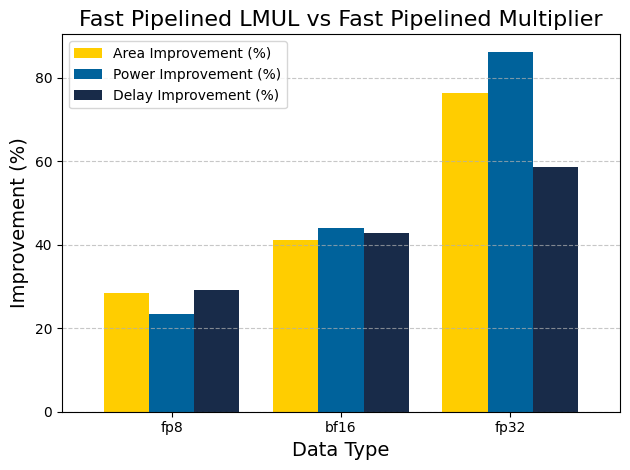

In [ ]:
# Filter for fast pipelined multiplier and lmul implementations
fast_pipelined_mask = (
    df["name"].str.contains("multiplier_pipelined") & df["name"].str.contains("fast")
) | (df["name"].str.contains("lmul_pipelined") & df["name"].str.contains("fast"))
fast_pipelined_df = df[fast_pipelined_mask].copy()

# Group by dtype and operation
grouped = (
    fast_pipelined_df.groupby(["dtype_order", "operation"])
    .agg({"area": "mean", "power": "mean", "max_arrival_time": "mean"})
    .reset_index()
)

# Pivot to get multiplier and lmul side by side
pivot_area = grouped.pivot(index="dtype_order", columns="operation", values="area")
pivot_power = grouped.pivot(index="dtype_order", columns="operation", values="power")
pivot_delay = grouped.pivot(
    index="dtype_order", columns="operation", values="max_arrival_time"
)

# Calculate percentage improvement
area_improvement = (1 - pivot_area["lmul"] / pivot_area["multiplier"]) * 100
power_improvement = (1 - pivot_power["lmul"] / pivot_power["multiplier"]) * 100
delay_improvement = (1 - pivot_delay["lmul"] / pivot_delay["multiplier"]) * 100

# Create a DataFrame with the improvements
improvements = pd.DataFrame(
    {
        "Area Improvement (%)": area_improvement,
        "Power Improvement (%)": power_improvement,
        "Delay Improvement (%)": delay_improvement,
    }
)

# Create a DataFrame with absolute values for labeling
abs_values = pd.DataFrame(
    {
        "Area (LMUL)": pivot_area["lmul"],
        "Area (Mult)": pivot_area["multiplier"],
        "Power (LMUL)": pivot_power["lmul"],
        "Power (Mult)": pivot_power["multiplier"],
        "Delay (LMUL)": pivot_delay["lmul"],
        "Delay (Mult)": pivot_delay["multiplier"],
    }
)

# Create the visualization
plt.figure(figsize=(16, 10))
ax = improvements.plot(kind="bar", rot=0, width=0.8)
plt.title("Fast Pipelined LMUL vs Fast Pipelined Multiplier", fontsize=16)
plt.ylabel("Improvement (%)", fontsize=14)
plt.xlabel("Data Type", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    # Calculate the position for the text
    height = p.get_height()
    x_pos = p.get_x() + p.get_width() / 2
    y_pos = height + 1 if height > 0 else height - 5

    # Determine which metric and dtype we're looking at
    metric_idx = i // len(improvements)
    dtype_idx = i % len(improvements)

    # Get the corresponding absolute values
    if metric_idx == 0:  # Area
        lmul_val = abs_values["Area (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Area (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.0f} vs {mult_val:.0f} μm²)"
    elif metric_idx == 1:  # Power
        lmul_val = abs_values["Power (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Power (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.2f} vs {mult_val:.2f} mW)"
    else:  # Delay
        lmul_val = abs_values["Delay (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Delay (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.2f} vs {mult_val:.2f} ns)"

    # Add the text
    # ax.text(x_pos, y_pos, label, ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_lmul_vs_multiplier_no_label.png"), dpi=700
)
plt.show()

## Absolute comparison by metric, then by dtype


### Separate plot version


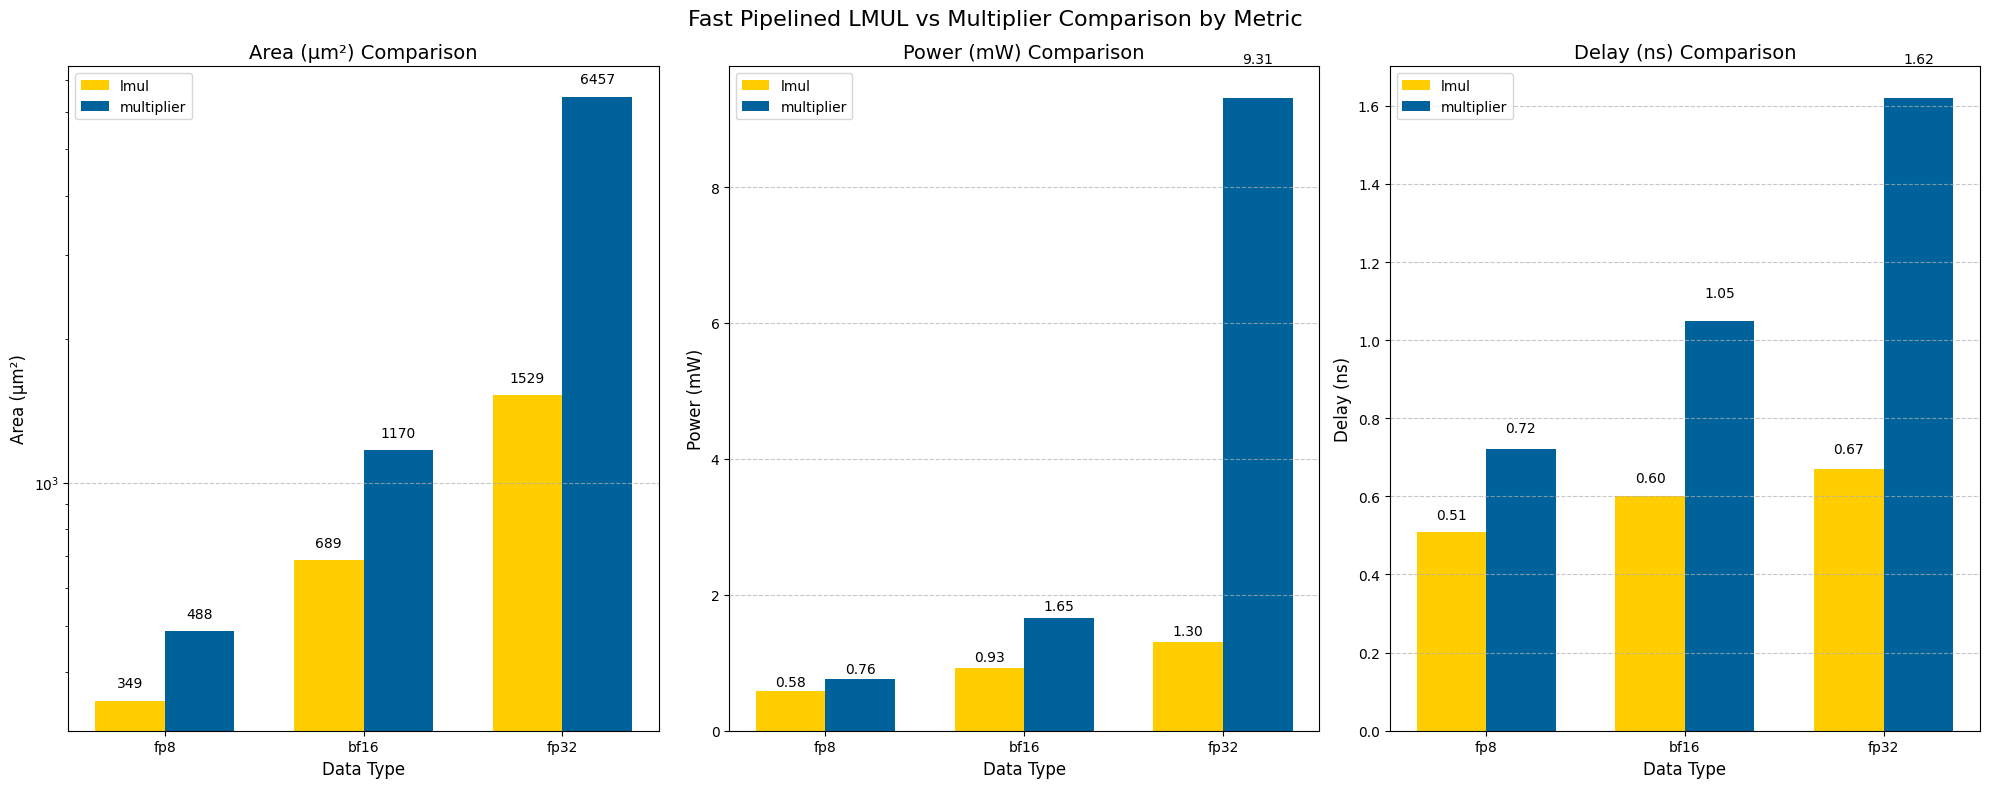

In [177]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.35

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        for dtype in ["fp8", "bf16", "fp32"]:
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)

        # Plot the bars
        pos = index + (j - 0.5) * bar_width
        bars = ax.bar(pos, values, bar_width, label=op)

        # Add value labels
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            else:
                label = f"{height:.2f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=10,
            )

    # Customize subplot
    ax.set_xlabel("Data Type", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f"{metric} Comparison", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

    # Use log scale for area plot
    if metric == "Area (μm²)":
        ax.set_yscale("log")

plt.suptitle("Fast Pipelined LMUL vs Multiplier Comparison by Metric", fontsize=16)
plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
# )
plt.show()

fp8 colors: lmul = #F3E500, multiplier= #00C6D7
bf16 colors: lmul = #FFCD00, multiplier= #00629B
fp32 colors: lmul = #C69214, multiplier= #182B49


### merged version


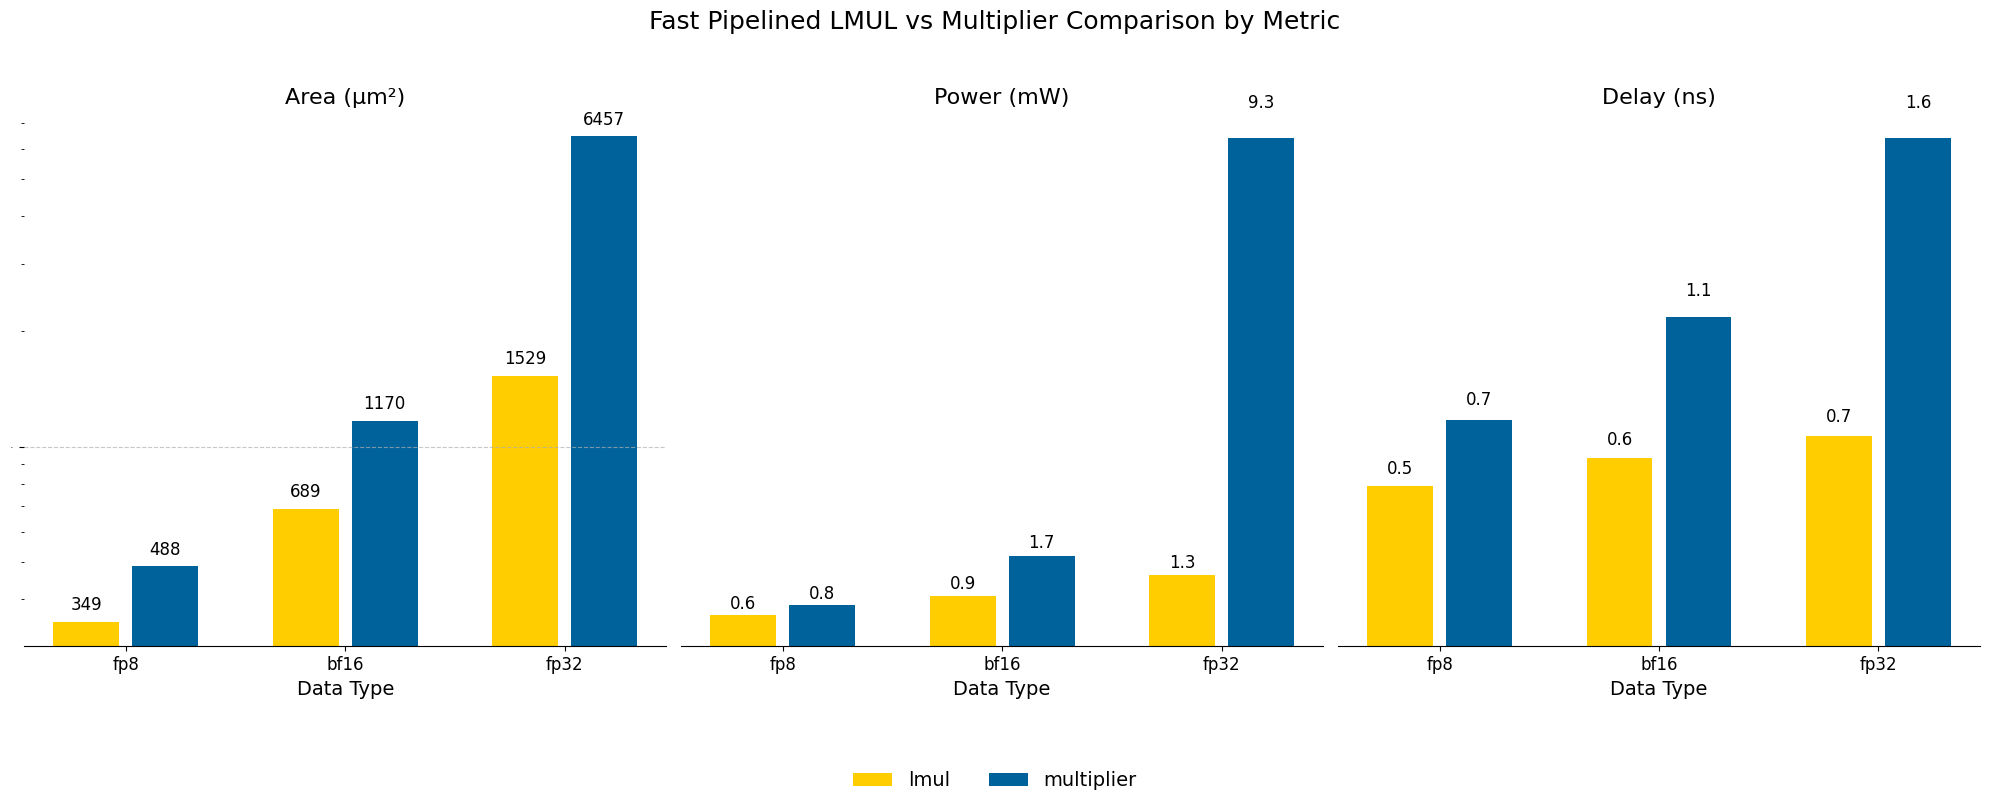

In [ ]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define custom colors as specified
colors = {
    # 'fp8': {'lmul': '#F3E500', 'multiplier': '#00C6D7'},
    "fp8": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "fp32": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    # 'fp32': {'lmul': '#C69214', 'multiplier': '#182B49'}
}

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.3  # Slightly narrower bars to add spacing

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        colors_list = []
        for k, dtype in enumerate(["fp8", "bf16", "fp32"]):
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)
            colors_list.append(colors[dtype][op])

        # Plot the bars with spacing between bars in the same group
        pos = index + (j - 0.5) * bar_width * 1.2  # Add 20% spacing between bars
        bars = ax.bar(
            pos, values, bar_width, label=op if i == 0 else "", color=colors_list
        )

        # Add value labels
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            elif metric == "Power (mW)":
                label = f"{height:.1f}"
            else:  # Frequency
                label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=12,
            )

    # Customize subplot
    ax.set_xlabel("Data Type", fontsize=14)
    ax.set_title(f"{metric}", fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"], fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Remove y-axis entirely
    ax.set_ylabel("")
    ax.set_yticks([])

    # Remove all borders
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)

    # Use log scale for area plot (even though y-axis is hidden)
    if metric == "Area (μm²)":
        ax.set_yscale("log")

    # Increase tick label font size
    ax.tick_params(axis="x", which="major", labelsize=12)
    ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    fontsize=14,
    ncol=2,
    frameon=False,
)

plt.suptitle("Fast Pipelined LMUL vs Multiplier Comparison by Metric", fontsize=18)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
)
plt.show()

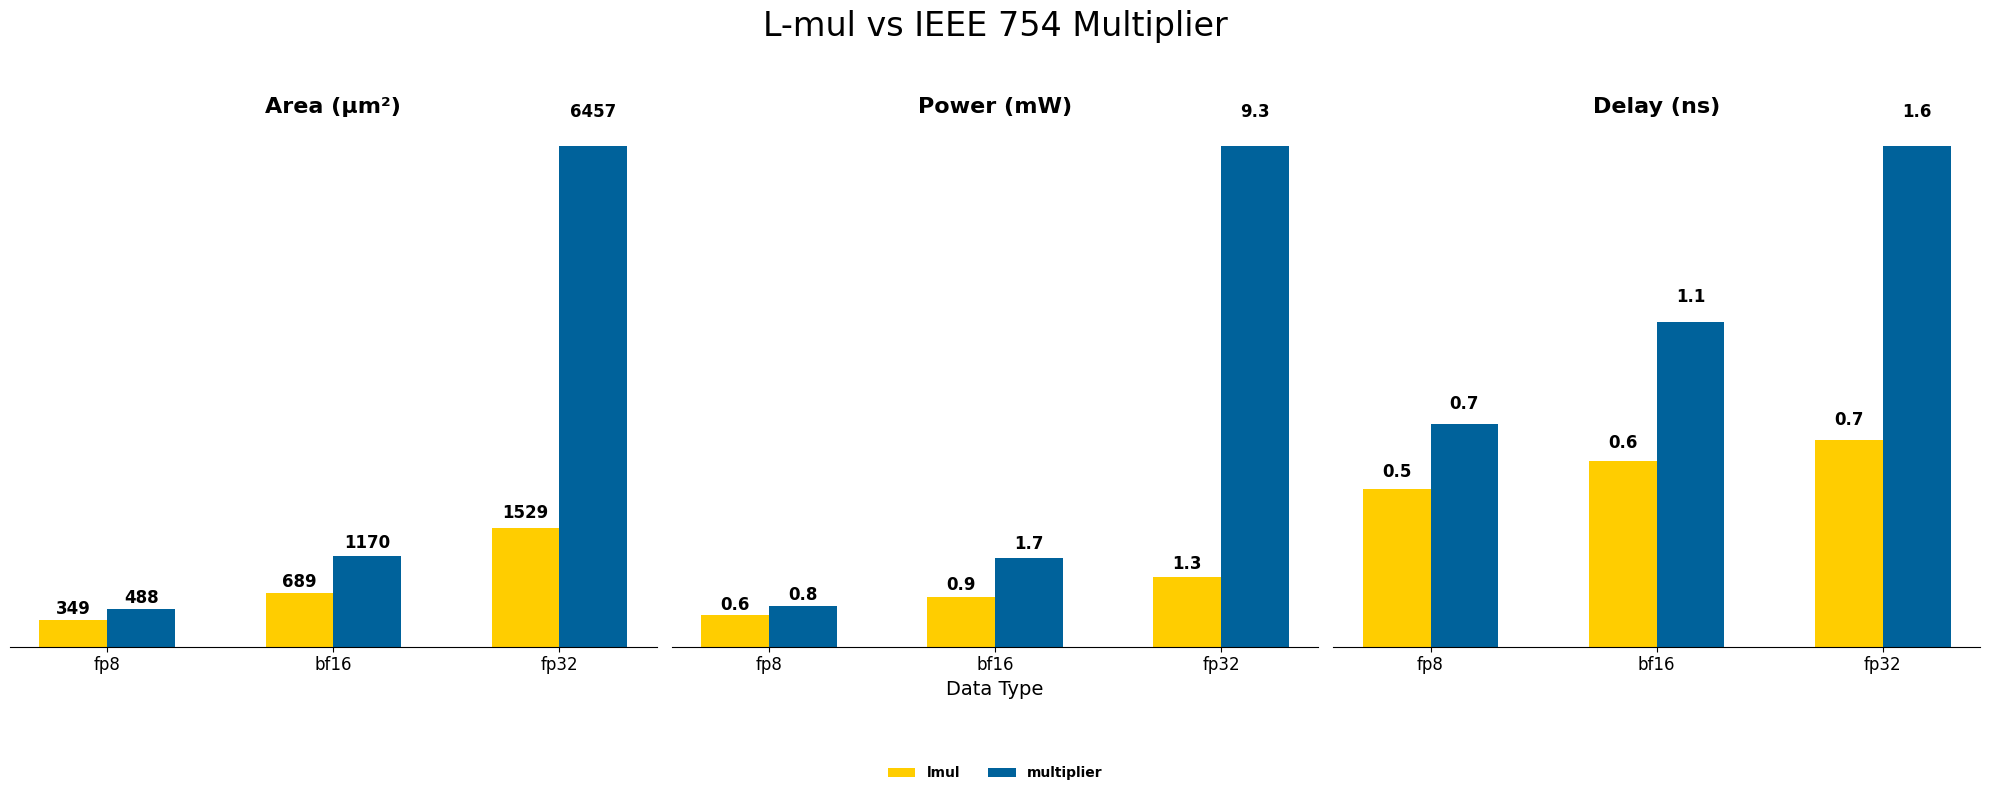

In [83]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define custom colors as specified
colors = {
    # 'fp8': {'lmul': '#F3E500', 'multiplier': '#00C6D7'},
    "fp8": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "fp32": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    # 'fp32': {'lmul': '#C69214', 'multiplier': '#182B49'}
}
metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.3  # Slightly narrower bars to add spacing

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        colors_list = []
        for k, dtype in enumerate(["fp8", "bf16", "fp32"]):
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)
            colors_list.append(colors[dtype][op])

        # Plot the bars with spacing between bars in the same group
        pos = index + (j - 0.5) * bar_width  # * 1.2  # Add 20% spacing between bars
        bars = ax.bar(
            pos, values, bar_width, label=op if i == 0 else "", color=colors_list
        )

        # Add value labels with bold font
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            elif metric == "Power (mW)":
                label = f"{height:.1f}"
            else:  # Frequency
                label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )

    # Customize subplot with bold fonts
    if i == 1:
        ax.set_xlabel("Data Type", fontsize=14)
    ax.set_title(f"{metric}", fontsize=16, fontweight="bold")
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"], fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Remove y-axis entirely
    ax.set_ylabel("")
    ax.set_yticks([])

    # Remove ALL borders/spines for every subplot
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

    # Add back just the bottom spine
    ax.spines["bottom"].set_visible(True)

    # Use log scale for area plot (even though y-axis is hidden)
    # if metric == "Area (μm²)":
    # ax.set_yscale("log")

    # Increase tick label font size and make bold
    ax.tick_params(axis="x", which="major", labelsize=12)
    ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

# Create a single legend for the entire figure with bold font
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    fontsize=36,
    ncol=2,
    frameon=False,
    prop={"weight": "bold"},
)

# Make the main title bold
plt.suptitle(
    "L-mul vs IEEE 754 Multiplier",
    fontsize=24,
    # fontweight="bold",
)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
)
plt.show()

### XKCD version


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

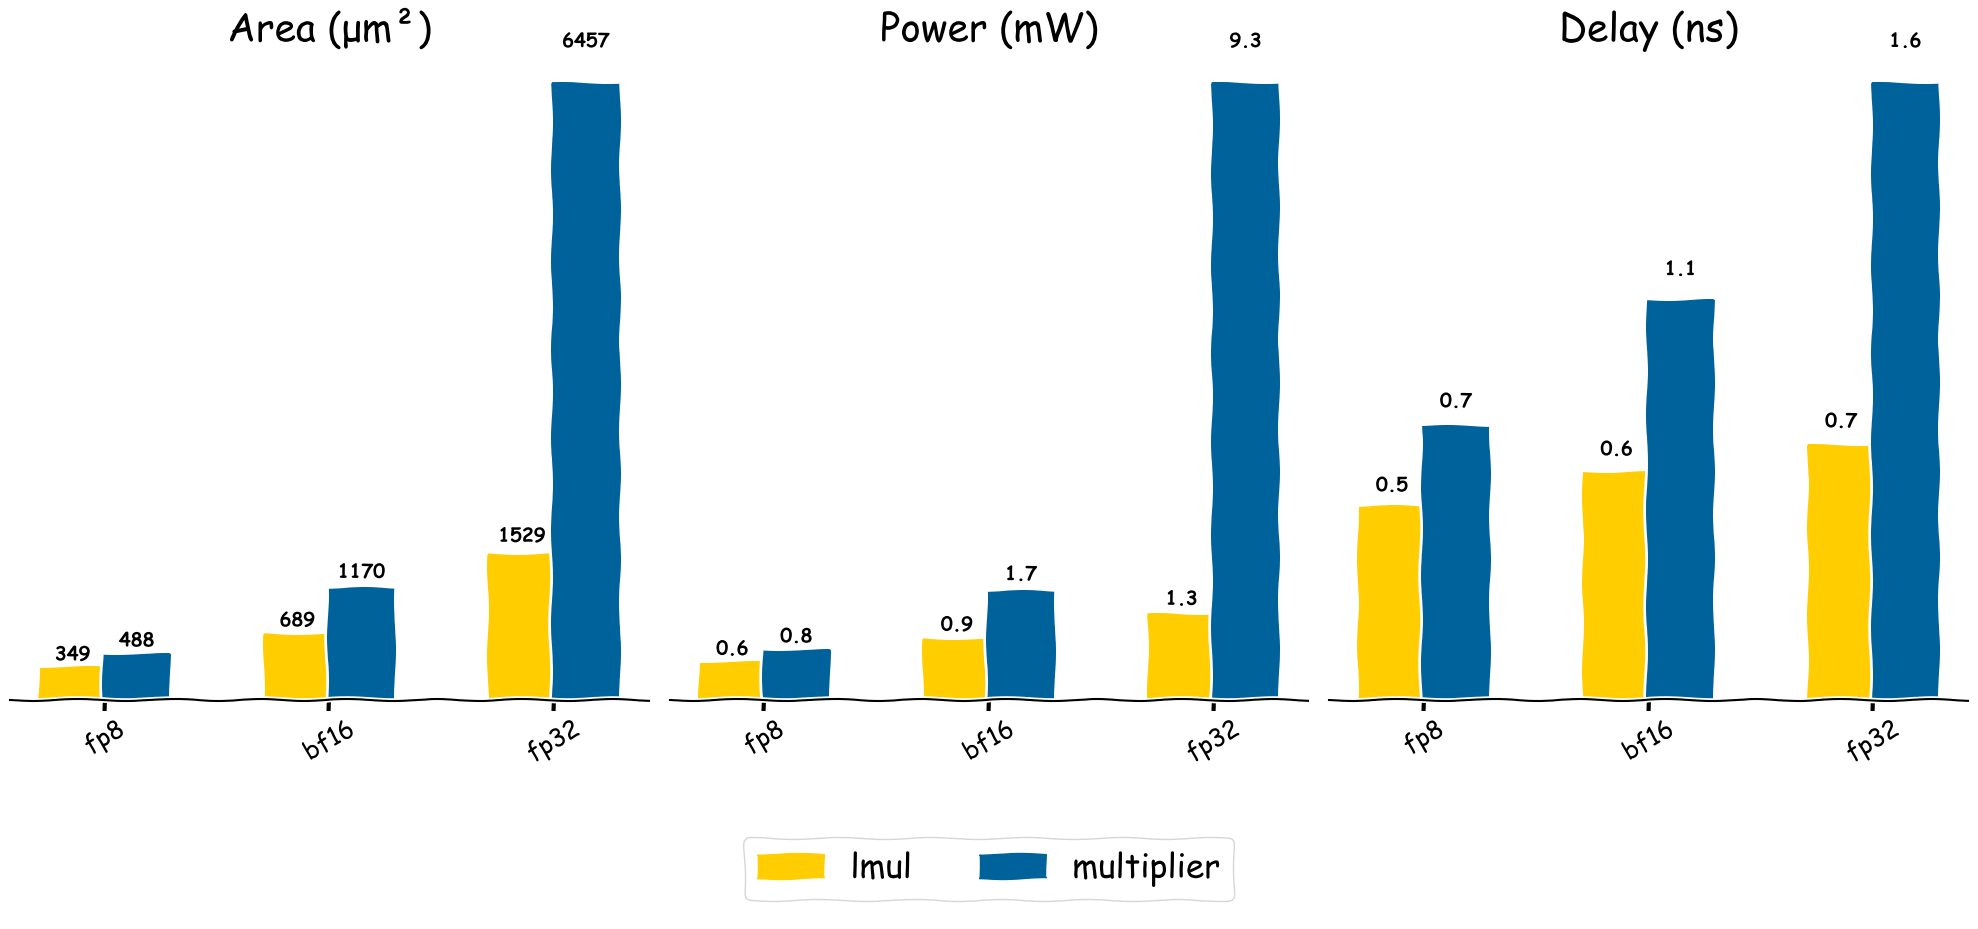

In [ ]:
with plt.xkcd():
    # Create a second version with separate subplots for each metric for better readability
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Define custom colors as specified
    colors = {
        "fp8": {"lmul": "#FFCD00", "multiplier": "#00629B"},
        "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
        "fp32": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    }
    metrics = list(metric_labels.values())
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Filter data for this metric
        metric_data = melted_df[melted_df["metric"] == metric]

        # Set positions for bars
        n_groups = 3  # fp8, bf16, fp32
        index = np.arange(n_groups)
        bar_width = 0.3  # Keep original bar width

        # Plot bars for lmul and multiplier
        for j, op in enumerate(["lmul", "multiplier"]):
            # Filter data for this operation
            op_data = metric_data[metric_data["operation"] == op]

            # Get values for each dtype
            values = []
            colors_list = []
            for k, dtype in enumerate(["fp8", "bf16", "fp32"]):
                val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
                values.append(val)
                colors_list.append(colors[dtype][op])

            # Plot the bars with reduced spacing
            # Use a smaller offset to bring bars closer together
            pos = index + (j - 0.5) * bar_width * 0.95  # Slightly reduce spacing
            bars = ax.bar(
                pos, values, bar_width, label=op if i == 0 else "", color=colors_list
            )

            # Add value labels with bold font
            for k, bar in enumerate(bars):
                height = bar.get_height()
                if metric == "Area (μm²)":
                    label = f"{height:.0f}"
                elif metric == "Power (mW)":
                    label = f"{height:.1f}"
                else:  # Frequency
                    label = f"{height:.1f}"
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.05 * height,
                    label,
                    ha="center",
                    va="bottom",
                    fontsize=14,
                    fontweight="bold",
                )

        # Customize subplot with bold fonts
        # if i == 1:
        # ax.set_xlabel("Data Type", fontsize=24)
        ax.set_title(
            f"{metric}",
            fontsize=28,
        )  # fontweight='bold')
        ax.set_xticks(index)
        ax.set_xticklabels(["fp8", "bf16", "fp32"])
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Remove y-axis entirely
        ax.set_ylabel("")
        ax.set_yticks([])

        # Remove ALL borders/spines for every subplot
        for spine in ["top", "right", "left", "bottom"]:
            ax.spines[spine].set_visible(False)

        # Add back just the bottom spine
        ax.spines["bottom"].set_visible(True)

        # Increase tick label font size and make itali
        ax.tick_params(axis="x", which="major", labelsize=18, rotation=30)
        ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

    # Make the main title
    # plt.suptitle(
    #     "L-mul vs IEEE 754 Multiplier",
    #     fontsize=24,
    # )

    # Adjust layout but leave space at the bottom for legend
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])

    # Create a custom legend with larger text
    # Get handles and labels from the first subplot
    handles, labels = axes[0].get_legend_handles_labels()

    # Create a new axis just for the legend
    legend_ax = fig.add_axes([0.3, 0.02, 0.4, 0.1])  # [left, bottom, width, height]
    legend_ax.axis("off")

    # Add custom legend patches with the correct colors
    import matplotlib.patches as mpatches

    lmul_patch = mpatches.Patch(color=colors["fp8"]["lmul"], label="lmul")
    multiplier_patch = mpatches.Patch(
        color=colors["fp8"]["multiplier"], label="multiplier"
    )

    # Add the legend with large font size
    legend = legend_ax.legend(
        handles=[lmul_patch, multiplier_patch],
        loc="center",
        ncol=2,
        # frameon=False,
        prop={"size": 24, "weight": "normal"},  # Non-bold text
    )
    # plt.savefig(
    #     os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
    # )
    plt.show()

In [134]:
melted_df

name dtype_order   operation      metric  \
0         lmul_pipelined_fast_bf16        bf16        lmul  Area (μm²)   
1         lmul_pipelined_fast_fp32        fp32        lmul  Area (μm²)   
2          lmul_pipelined_fast_fp8         fp8        lmul  Area (μm²)   
3   multiplier_pipelined_fast_bf16        bf16  multiplier  Area (μm²)   
4   multiplier_pipelined_fast_fp32        fp32  multiplier  Area (μm²)   
5    multiplier_pipelined_fast_fp8         fp8  multiplier  Area (μm²)   
6         lmul_pipelined_fast_bf16        bf16        lmul  Power (mW)   
7         lmul_pipelined_fast_fp32        fp32        lmul  Power (mW)   
8          lmul_pipelined_fast_fp8         fp8        lmul  Power (mW)   
9   multiplier_pipelined_fast_bf16        bf16  multiplier  Power (mW)   
10  multiplier_pipelined_fast_fp32        fp32  multiplier  Power (mW)   
11   multiplier_pipelined_fast_fp8         fp8  multiplier  Power (mW)   
12        lmul_pipelined_fast_bf16        bf16        lmul  Delay (ns)   
13        lmul_pipelined_fast_fp32        fp32        lmul  Delay (ns)   
14         lmul_pipelined_fast_fp8         fp8        lmul  Delay (ns)   
15  multiplier_pipelined_fast_bf16        bf16  multiplier  Delay (ns)   
16  multiplier_pipelined_fast_fp32        fp32  multiplier  Delay (ns)   
17   multiplier_pipelined_fast_fp8         fp8  multiplier  Delay (ns)   

          value  
0    688.674000  
1   1529.230000  
2    348.726000  
3   1169.600000  
4   6457.420000  
5    487.578000  
6      0.928291  
7      1.300250  
8      0.582629  
9      1.654080  
10     9.310730  
11     0.761612  
12     0.600000  
13     0.670000  
14     0.510000  
15     1.050000  
16     1.620000  
17     0.720000

## Compare metrics, stacked dtype


### XKCD Version


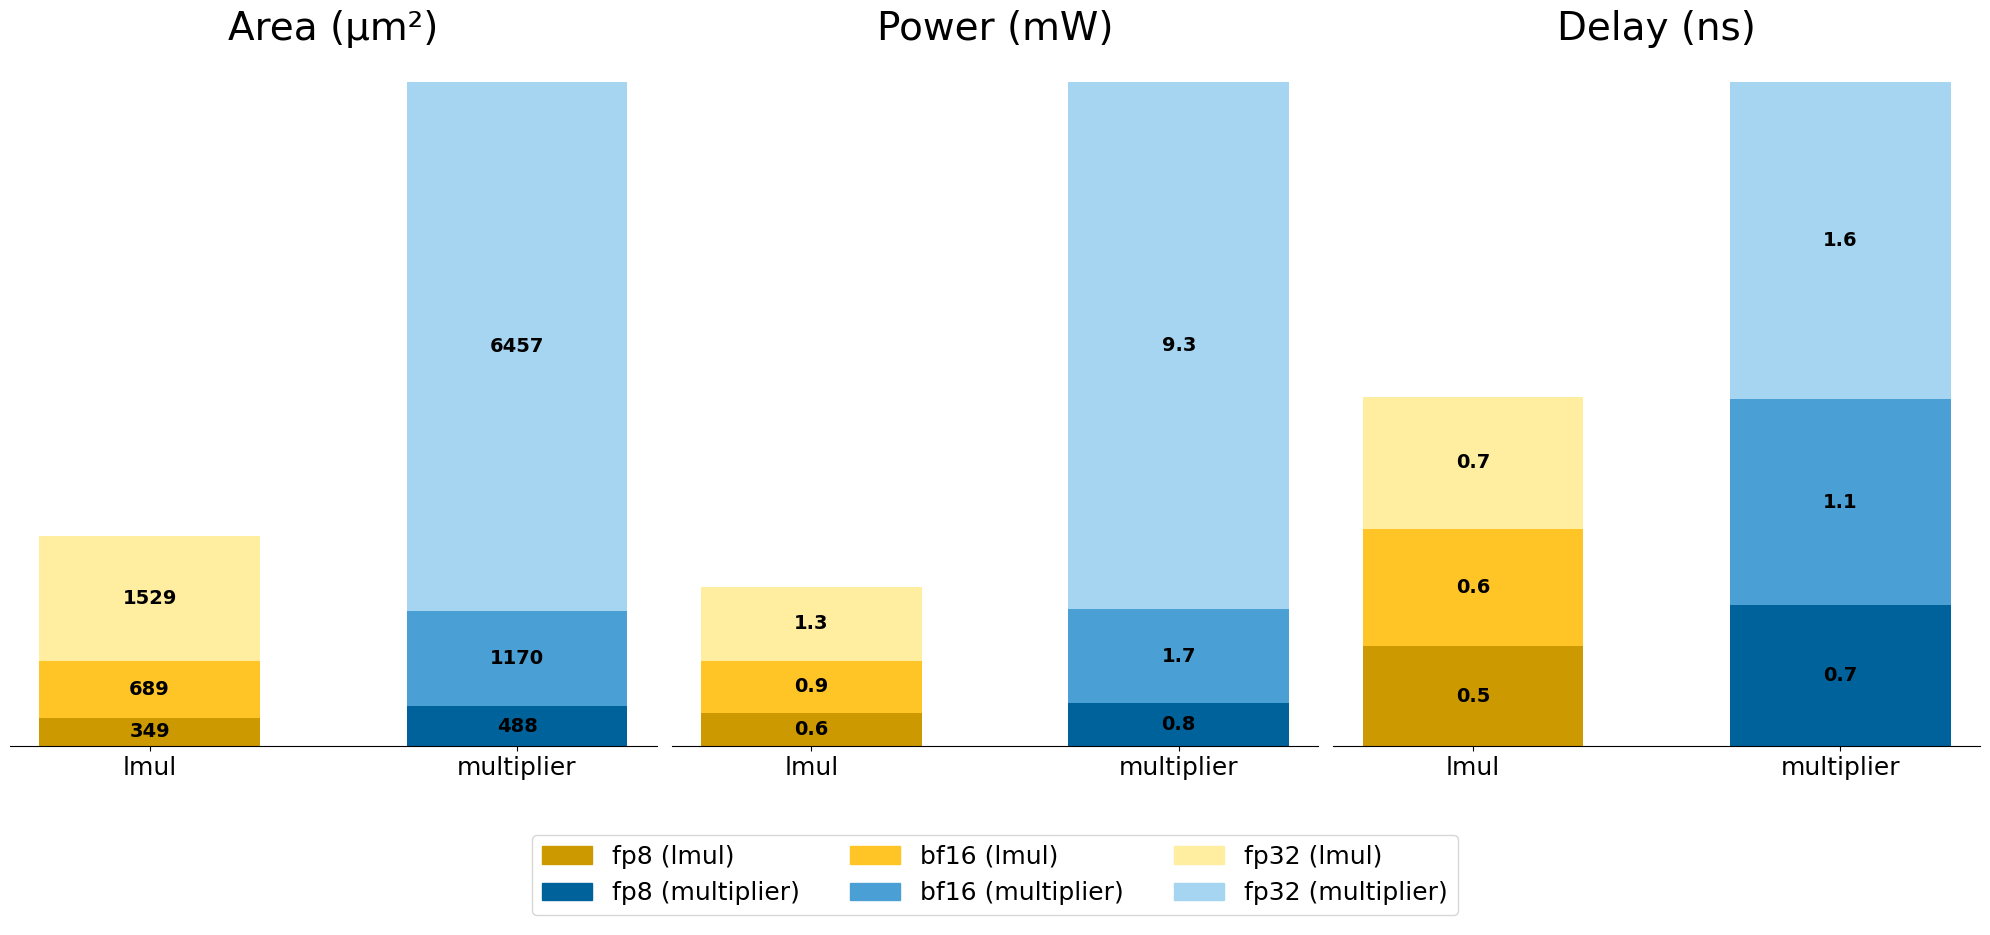

In [ ]:
# with plt.xkcd():
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Define custom colors with darker shades for higher precision
colors = {
    "fp32": {"lmul": "#FFEDA0", "multiplier": "#A6D5F2"},  # Lightest
    "bf16": {"lmul": "#FFC425", "multiplier": "#4A9FD5"},  # Medium
    "fp8": {"lmul": "#CC9900", "multiplier": "#00629B"},  # Darkest
}

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    index = np.arange(2)  # Just 2 positions: lmul and multiplier
    bar_width = 0.6

    # For each operation (lmul, multiplier)
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        bottom = 0
        for dtype in ["fp8", "bf16", "fp32"]:  # Order from lowest to highest precision
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()

            # Plot the stacked bar
            bar = ax.bar(
                j,
                val,
                bar_width,
                bottom=bottom,
                label=f"{dtype} {op}" if i == 0 else "",
                color=colors[dtype][op],
            )

            # Add value labels with bold font
            height = bar[0].get_height()
            if height > 0.05 * (bottom + height):  # Only label if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{height:.0f}"
                elif metric == "Power (mW)":
                    label = f"{height:.1f}"
                else:  # Frequency
                    label = f"{height:.1f}"

                ax.text(
                    j,
                    bottom + height / 2,
                    label,
                    ha="center",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    # color="white"  # White text on dark backgrounds
                    color="black",
                    # color="white" if dtype != "fp32" else "#444444"  # White text on dark backgrounds
                )

            bottom += val

    # Customize subplot with bold fonts
    ax.set_title(f"{metric}", fontsize=28)
    ax.set_xticks(index)
    ax.set_xticklabels(["lmul", "multiplier"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Remove y-axis entirely
    ax.set_ylabel("")
    ax.set_yticks([])

    # Remove ALL borders/spines for every subplot
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

    # Add back just the bottom spine
    ax.spines["bottom"].set_visible(True)

    # Increase tick label font size
    ax.tick_params(axis="x", which="major", labelsize=18, rotation=0)
    ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

# Adjust layout
plt.tight_layout(rect=[0, 0.15, 1, 0.95])

# Create a custom legend
legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.1])  # [left, bottom, width, height]
legend_ax.axis("off")

# Add custom legend patches with the correct colors
import matplotlib.patches as mpatches

patches = []
for dtype in ["fp8", "bf16", "fp32"]:
    lmul_patch = mpatches.Patch(color=colors[dtype]["lmul"], label=f"{dtype} (lmul)")
    multiplier_patch = mpatches.Patch(
        color=colors[dtype]["multiplier"], label=f"{dtype} (multiplier)"
    )
    patches.extend([lmul_patch, multiplier_patch])

# Add the legend with large font size
legend = legend_ax.legend(
    handles=patches, loc="center", ncol=3, prop={"size": 18, "weight": "normal"}
)

# plt.savefig(
#     os.path.join(SAVE_DIR, "fast_pipelined_stacked_comparison_by_metric.png"), dpi=300
# )
plt.show()

### Separate plots version


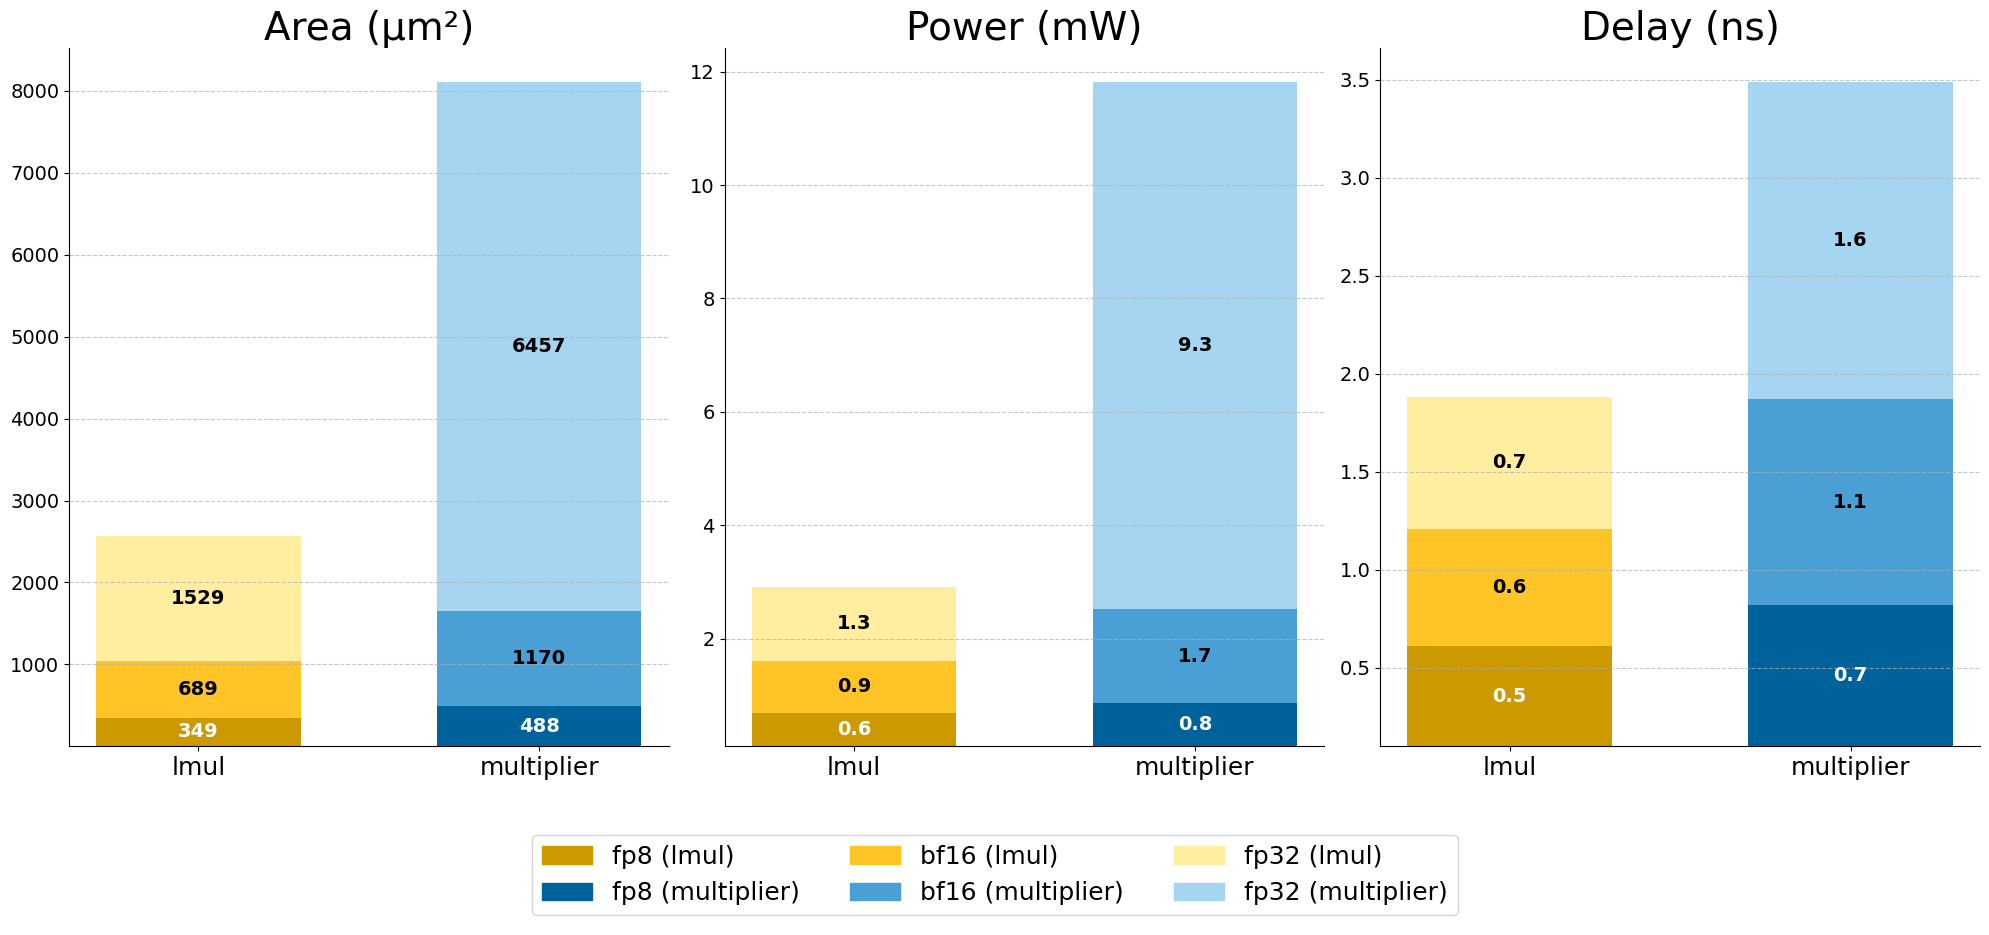

In [ ]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Define custom colors with darker shades for lower precision (reversed)
colors = {
    "fp8": {"lmul": "#CC9900", "multiplier": "#00629B"},  # Darkest
    "bf16": {"lmul": "#FFC425", "multiplier": "#4A9FD5"},  # Medium
    "fp32": {"lmul": "#FFEDA0", "multiplier": "#A6D5F2"},  # Lightest
}

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Set logarithmic scale for y-axis
    # ax.set_yscale('log')

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    index = np.arange(2)  # Just 2 positions: lmul and multiplier
    bar_width = 0.6

    # For each operation (lmul, multiplier)
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        bottom = 0.1  # Start slightly above zero for log scale
        for dtype in ["fp8", "bf16", "fp32"]:  # Order from lowest to highest precision
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()

            # Plot the stacked bar
            bar = ax.bar(
                j,
                val,
                bar_width,
                bottom=bottom,
                label=f"{dtype} {op}" if i == 0 else "",
                color=colors[dtype][op],
            )

            # Add value labels with bold font
            height = bar[0].get_height()
            if height > 0.05 * bottom:  # Only label if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{height:.0f}"
                elif metric == "Power (mW)":
                    label = f"{height:.1f}"
                else:  # Frequency
                    label = f"{height:.1f}"

                ax.text(
                    j,
                    bottom + height / 2,
                    label,
                    ha="center",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    color=(
                        "white" if dtype == "fp8" else "black"
                    ),  # White text on dark backgrounds
                )

            bottom += val

    # Customize subplot with bold fonts
    ax.set_title(f"{metric}", fontsize=28)
    ax.set_xticks(index)
    ax.set_xticklabels(["lmul", "multiplier"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Show y-axis for log scale
    ax.set_ylabel("")

    # Format y-axis ticks for log scale
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    # Remove borders/spines except for left and bottom
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_visible(True)

    # Increase tick label font size
    ax.tick_params(axis="x", which="major", labelsize=18, rotation=0)
    ax.tick_params(axis="y", which="major", labelsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.15, 1, 0.95])

# Create a custom legend
legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.1])  # [left, bottom, width, height]
legend_ax.axis("off")

# Add custom legend patches with the correct colors
import matplotlib.patches as mpatches

patches = []
for dtype in ["fp8", "bf16", "fp32"]:
    lmul_patch = mpatches.Patch(color=colors[dtype]["lmul"], label=f"{dtype} (lmul)")
    multiplier_patch = mpatches.Patch(
        color=colors[dtype]["multiplier"], label=f"{dtype} (multiplier)"
    )
    patches.extend([lmul_patch, multiplier_patch])

# Add the legend with large font size
legend = legend_ax.legend(
    handles=patches, loc="center", ncol=3, prop={"size": 18, "weight": "normal"}
)

plt.savefig(
    os.path.join(SAVE_DIR, "lmul_comparison_by_metric_stacked_dtype.png"), dpi=300
)
plt.show()

### Merged and stacked plots version


/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3122729603.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


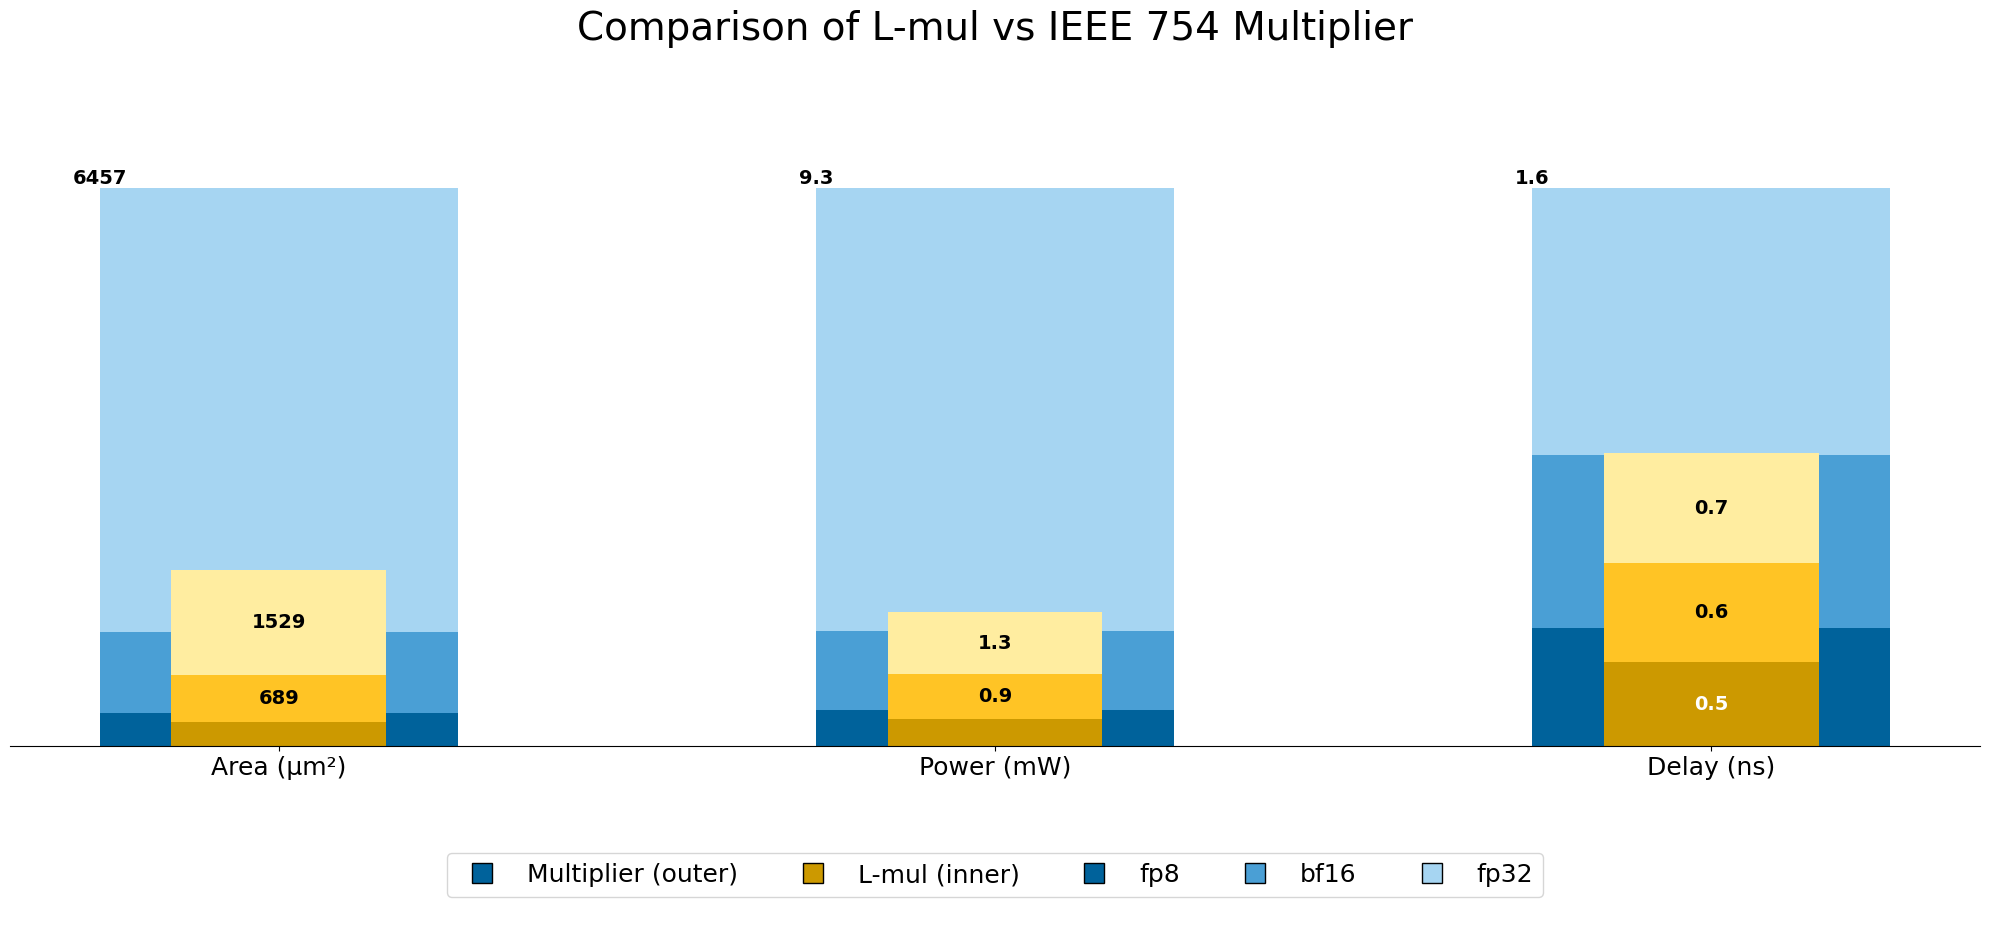

In [ ]:
# Create a visualization with nested bars for all metrics on one plot
# with independent scaling for each metric
fig, ax = plt.subplots(figsize=(20, 10))

# Define custom colors with darker shades for lower precision
colors = {
    "fp32": {"lmul": "#FFEDA0", "multiplier": "#A6D5F2"},  # Lightest
    "bf16": {"lmul": "#FFC425", "multiplier": "#4A9FD5"},  # Medium
    "fp8": {"lmul": "#CC9900", "multiplier": "#00629B"},  # Darkest
}

# Make bars skinnier
bar_width = 0.5  # Width of the outer (multiplier) bar
inner_width_ratio = 0.6  # lmul bar width as a fraction of multiplier bar width

metrics = list(metric_labels.values())
x_positions = np.arange(len(metrics))

# Calculate the maximum value for each metric to use for scaling
max_values = {}
for i, metric in enumerate(metrics):
    metric_data = melted_df[melted_df["metric"] == metric]

    # Calculate total height for both operations
    max_mult = 0
    max_lmul = 0

    for op in ["multiplier", "lmul"]:
        op_data = metric_data[metric_data["operation"] == op]
        total = 0
        for dtype in ["fp8", "bf16", "fp32"]:
            dtype_data = op_data[op_data["dtype_order"] == dtype]
            if not dtype_data.empty:
                total += dtype_data["value"].mean()

        if op == "multiplier":
            max_mult = total
        else:
            max_lmul = total

    # Use the larger of the two as the max value for this metric
    max_values[metric] = max(max_mult, max_lmul)

# For each metric
for i, metric in enumerate(metrics):
    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Get the scaling factor for this metric
    scale_factor = 0.8 / max_values[metric]  # Scale to 80% of plot height

    # First, plot the multiplier bars (wider, blue)
    bottom_mult = 0
    for dtype in ["fp8", "bf16", "fp32"]:
        mult_data = metric_data[
            (metric_data["operation"] == "multiplier")
            & (metric_data["dtype_order"] == dtype)
        ]
        if not mult_data.empty:
            val = mult_data["value"].mean()
            scaled_val = val * scale_factor

            # Plot the multiplier bar
            mult_bar = ax.bar(
                i,
                scaled_val,
                bar_width,
                bottom=bottom_mult,
                label=f"{dtype} (multiplier)" if i == 0 else "",
                color=colors[dtype]["multiplier"],
            )

            # Add value labels for multiplier (outside and to the left of the top edge)
            if val > 0.05 * max_values[metric]:  # Only label if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{val:.0f}"
                elif metric == "Power (mW)":
                    label = f"{val:.1f}"
                else:  # Frequency
                    label = f"{val:.1f}"

                # Position label outside and to the left of the top edge
                if dtype == "fp32":  # Only label the top of the stack
                    ax.text(
                        i - bar_width / 2,
                        bottom_mult + scaled_val,
                        label,
                        ha="center",
                        va="bottom",
                        fontsize=14,
                        fontweight="bold",
                        color="black",
                    )

            bottom_mult += scaled_val

    # Then, plot the lmul bars (narrower, yellow)
    bottom_lmul = 0
    for dtype in ["fp8", "bf16", "fp32"]:
        lmul_data = metric_data[
            (metric_data["operation"] == "lmul") & (metric_data["dtype_order"] == dtype)
        ]
        if not lmul_data.empty:
            val = lmul_data["value"].mean()
            scaled_val = val * scale_factor

            # Plot the lmul bar (narrower)
            lmul_bar = ax.bar(
                i,
                scaled_val,
                bar_width * inner_width_ratio,
                bottom=bottom_lmul,
                label=f"{dtype} (lmul)" if i == 0 else "",
                color=colors[dtype]["lmul"],
            )

            # Add value labels for lmul (inside the bars)
            if val > 0.05 * max_values[metric]:  # Only label if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{val:.0f}"
                elif metric == "Power (mW)":
                    label = f"{val:.1f}"
                else:  # Frequency
                    label = f"{val:.1f}"

                # Position label inside the bar
                ax.text(
                    i,
                    bottom_lmul + scaled_val / 2,
                    label,
                    ha="center",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    color="white" if dtype == "fp8" else "black",
                )

            bottom_lmul += scaled_val

# Customize plot
ax.set_title("Comparison of L-mul vs IEEE 754 Multiplier", fontsize=28)
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics, fontsize=18)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Remove y-axis entirely
ax.set_ylabel("")
ax.set_yticks([])
ax.set_ylim(0, 1)  # Set y-limit to 0-1 since we're scaling everything

# Remove ALL borders/spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Add back just the bottom spine
ax.spines["bottom"].set_visible(True)

# Create a custom legend
legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.1])  # [left, bottom, width, height]
legend_ax.axis("off")

# Create custom legend elements
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

legend_elements = []

# First add the operation type indicators
legend_elements.append(
    Line2D(
        [0],
        [0],
        color="black",
        lw=0,
        marker="s",
        markersize=15,
        markerfacecolor=colors["fp8"]["multiplier"],
        label="Multiplier (outer)",
    )
)
legend_elements.append(
    Line2D(
        [0],
        [0],
        color="black",
        lw=0,
        marker="s",
        markersize=15,
        markerfacecolor=colors["fp8"]["lmul"],
        label="L-mul (inner)",
    )
)

# Then add the precision type indicators
for dtype in ["fp8", "bf16", "fp32"]:
    legend_elements.append(
        Line2D(
            [0],
            [0],
            color="black",
            lw=0,
            marker="s",
            markersize=15,
            markerfacecolor=colors[dtype]["multiplier"],
            label=f"{dtype}",
        )
    )

# Add the legend with large font size
legend = legend_ax.legend(
    handles=legend_elements, loc="center", ncol=5, prop={"size": 18, "weight": "normal"}
)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_nested_bars_all_metrics_scaled.png"), dpi=300
)
plt.show()

### Merged and stacked with annotations


/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/217690454.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


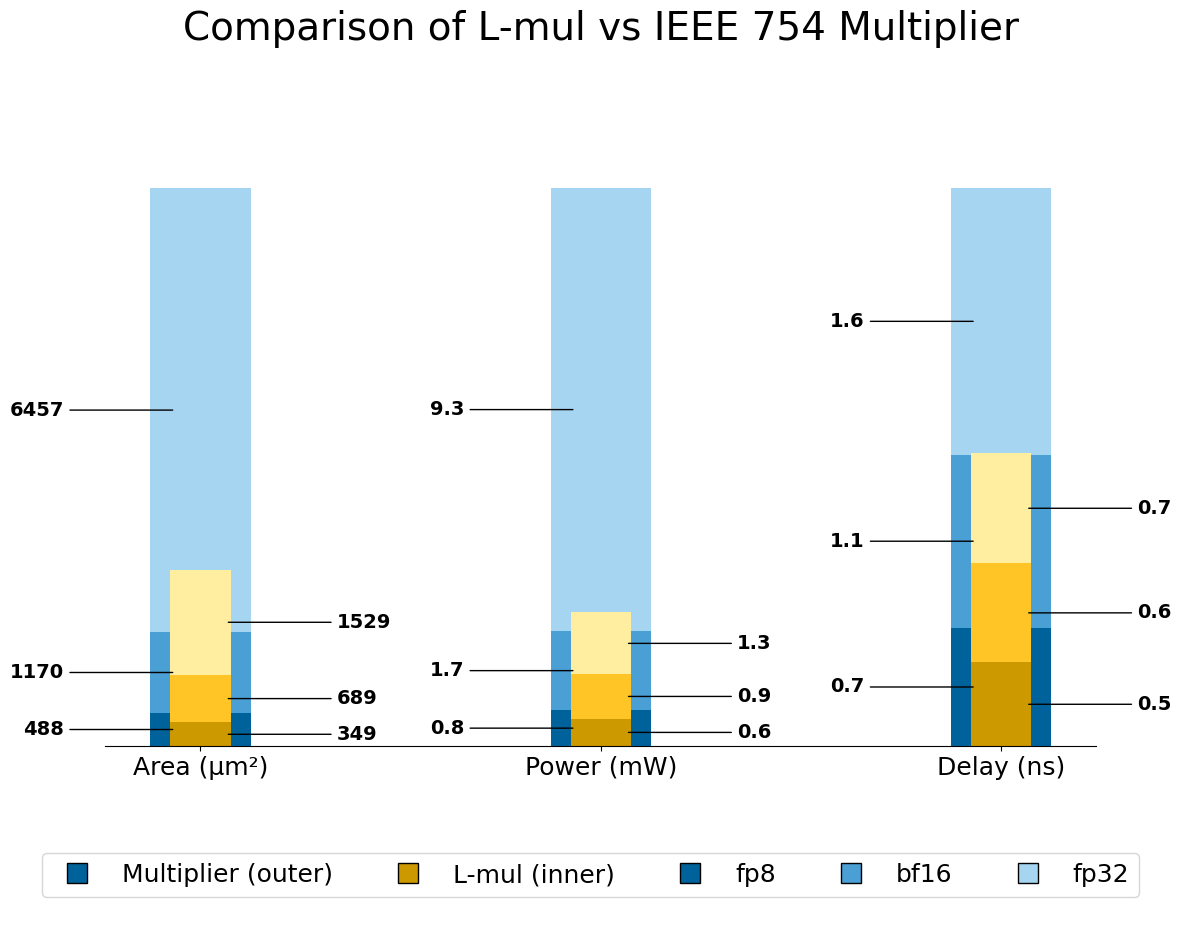

In [ ]:
# Create a visualization with nested bars for all metrics on one plot
# with annotations for each data type and connecting lines
fig, ax = plt.subplots(figsize=(12, 10))

# Define custom colors with darker shades for lower precision
colors = {
    "fp32": {"lmul": "#FFEDA0", "multiplier": "#A6D5F2"},  # Lightest
    "bf16": {"lmul": "#FFC425", "multiplier": "#4A9FD5"},  # Medium
    "fp8": {"lmul": "#CC9900", "multiplier": "#00629B"},  # Darkest
}

# Make bars skinnier
bar_width = 0.25  # Width of the outer (multiplier) bar
inner_width_ratio = 0.6  # lmul bar width as a fraction of multiplier bar width

metrics = list(metric_labels.values())
x_positions = np.arange(len(metrics))

# Calculate the maximum value for each metric to use for scaling
max_values = {}
for i, metric in enumerate(metrics):
    metric_data = melted_df[melted_df["metric"] == metric]

    # Calculate total height for both operations
    max_mult = 0
    max_lmul = 0

    for op in ["multiplier", "lmul"]:
        op_data = metric_data[metric_data["operation"] == op]
        total = 0
        for dtype in ["fp8", "bf16", "fp32"]:
            dtype_data = op_data[op_data["dtype_order"] == dtype]
            if not dtype_data.empty:
                total += dtype_data["value"].mean()

        if op == "multiplier":
            max_mult = total
        else:
            max_lmul = total

    # Use the larger of the two as the max value for this metric
    max_values[metric] = max(max_mult, max_lmul)

# For each metric
for i, metric in enumerate(metrics):
    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Get the scaling factor for this metric
    scale_factor = 0.8 / max_values[metric]  # Scale to 80% of plot height

    # First, plot the multiplier bars (wider, blue)
    bottom_mult = 0
    for dtype in ["fp8", "bf16", "fp32"]:
        mult_data = metric_data[
            (metric_data["operation"] == "multiplier")
            & (metric_data["dtype_order"] == dtype)
        ]
        if not mult_data.empty:
            val = mult_data["value"].mean()
            scaled_val = val * scale_factor

            # Plot the multiplier bar
            mult_bar = ax.bar(
                i,
                scaled_val,
                bar_width,
                bottom=bottom_mult,
                label=f"{dtype} (multiplier)" if i == 0 else "",
                color=colors[dtype]["multiplier"],
            )

            # Add annotation with connecting line for each multiplier dtype
            if val > 0.02 * max_values[metric]:  # Only annotate if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{val:.0f}"
                elif metric == "Power (mW)":
                    label = f"{val:.1f}"
                else:  # Frequency
                    label = f"{val:.1f}"

                # Create annotation with connecting line - moved further left
                ax.annotate(
                    label,
                    xy=(
                        i - bar_width / 4,
                        bottom_mult + scaled_val / 2,
                    ),  # Point on the bar
                    xytext=(-80, 0),  # Offset text further to the left
                    textcoords="offset points",
                    ha="right",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    color="black",
                    arrowprops=dict(
                        arrowstyle="-", color="black", connectionstyle="arc3,rad=0"
                    ),
                )

            bottom_mult += scaled_val

    # Then, plot the lmul bars (narrower, yellow)
    bottom_lmul = 0
    for dtype in ["fp8", "bf16", "fp32"]:
        lmul_data = metric_data[
            (metric_data["operation"] == "lmul") & (metric_data["dtype_order"] == dtype)
        ]
        if not lmul_data.empty:
            val = lmul_data["value"].mean()
            scaled_val = val * scale_factor

            # Plot the lmul bar (narrower)
            lmul_bar = ax.bar(
                i,
                scaled_val,
                bar_width * inner_width_ratio,
                bottom=bottom_lmul,
                label=f"{dtype} (lmul)" if i == 0 else "",
                color=colors[dtype]["lmul"],
            )

            # Add annotation with connecting line for each lmul dtype
            if val > 0.02 * max_values[metric]:  # Only annotate if bar is big enough
                if metric == "Area (μm²)":
                    label = f"{val:.0f}"
                elif metric == "Power (mW)":
                    label = f"{val:.1f}"
                else:  # Frequency
                    label = f"{val:.1f}"

                # Create annotation with connecting line - moved further right
                ax.annotate(
                    label,
                    xy=(
                        i + bar_width / 4,
                        bottom_lmul + scaled_val / 2,
                    ),  # Point on the bar
                    xytext=(80, 0),  # Offset text further to the right
                    textcoords="offset points",
                    ha="left",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    color="black",
                    arrowprops=dict(
                        arrowstyle="-", color="black", connectionstyle="arc3,rad=0"
                    ),
                )

            bottom_lmul += scaled_val

# Customize plot
ax.set_title("Comparison of L-mul vs IEEE 754 Multiplier", fontsize=28)
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics, fontsize=18)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Remove y-axis entirely
ax.set_ylabel("")
ax.set_yticks([])
ax.set_ylim(0, 1)  # Set y-limit to 0-1 since we're scaling everything

# Remove ALL borders/spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Add back just the bottom spine
ax.spines["bottom"].set_visible(True)

# Create a custom legend
legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.1])  # [left, bottom, width, height]
legend_ax.axis("off")

# Create custom legend elements
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

legend_elements = []

# First add the operation type indicators
legend_elements.append(
    Line2D(
        [0],
        [0],
        color="black",
        lw=0,
        marker="s",
        markersize=15,
        markerfacecolor=colors["fp8"]["multiplier"],
        label="Multiplier (outer)",
    )
)
legend_elements.append(
    Line2D(
        [0],
        [0],
        color="black",
        lw=0,
        marker="s",
        markersize=15,
        markerfacecolor=colors["fp8"]["lmul"],
        label="L-mul (inner)",
    )
)

# Then add the precision type indicators
for dtype in ["fp8", "bf16", "fp32"]:
    legend_elements.append(
        Line2D(
            [0],
            [0],
            color="black",
            lw=0,
            marker="s",
            markersize=15,
            markerfacecolor=colors[dtype]["multiplier"],
            label=f"{dtype}",
        )
    )

# Add the legend with large font size
legend = legend_ax.legend(
    handles=legend_elements, loc="center", ncol=5, prop={"size": 18, "weight": "normal"}
)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
# plt.savefig(
#     os.path.join(SAVE_DIR, "fast_pipelined_nested_bars_all_metrics_annotated.png"), dpi=300
# )
plt.show()

## Bubble chart area plot


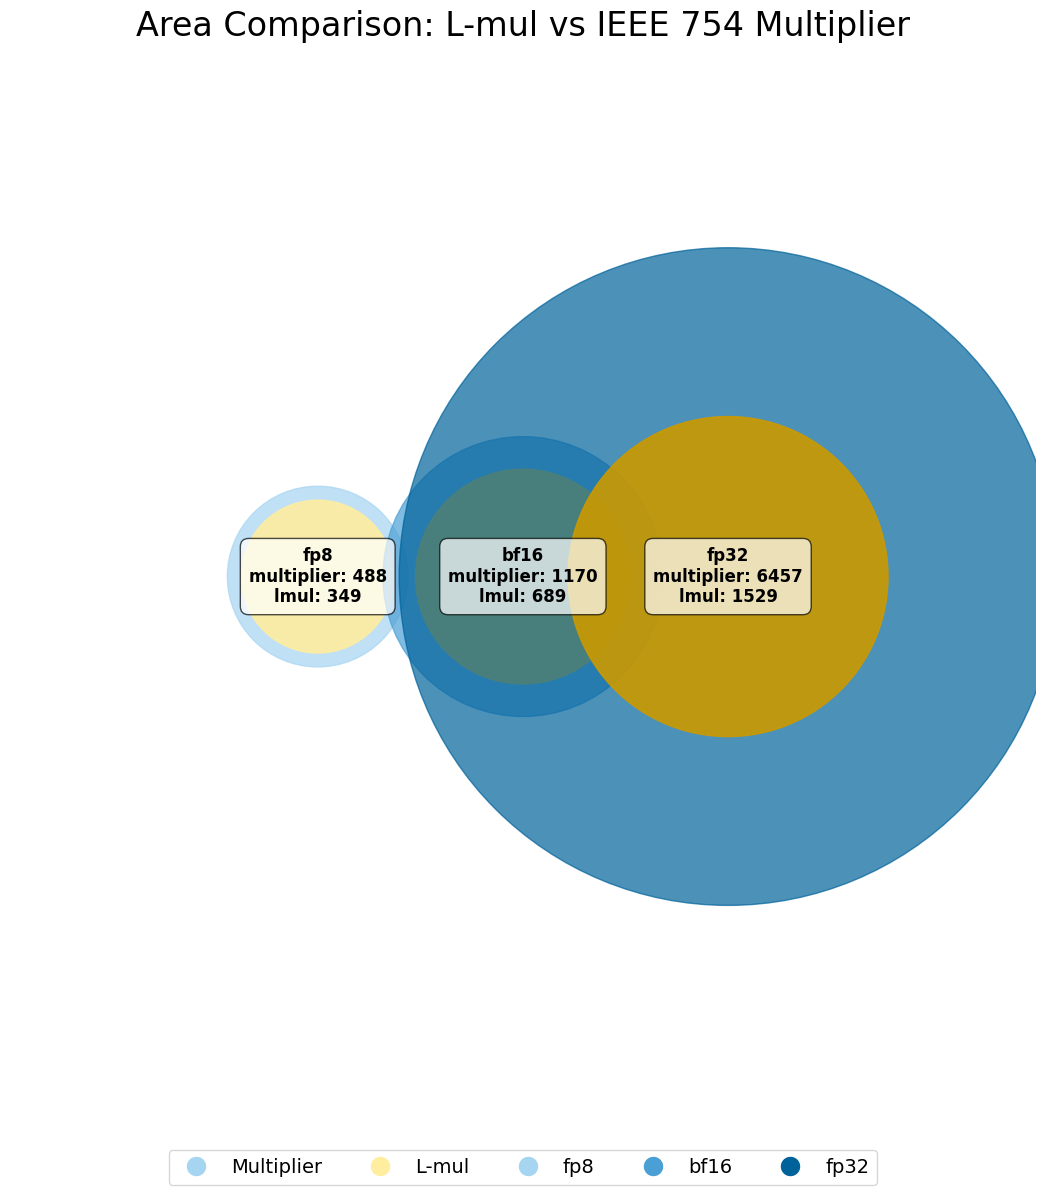

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Create a bubble chart visualization for area only
fig, ax = plt.subplots(figsize=(12, 12))

# Define custom colors with darker shades for lower precision
colors = {
    "fp8": {"lmul": "#FFEDA0", "multiplier": "#A6D5F2"},  # Lightest
    "bf16": {"lmul": "#FFC425", "multiplier": "#4A9FD5"},  # Medium
    "fp32": {"lmul": "#CC9900", "multiplier": "#00629B"},  # Darkest
}

# Filter data for area metric only
area_data = melted_df[melted_df["metric"] == "Area (μm²)"]

# Define positions for each dtype
positions = {"fp8": (0.3, 0.5), "bf16": (0.5, 0.5), "fp32": (0.7, 0.5)}

# Scale factor to convert area values to circle radii
# Area of circle = π * r², so r = sqrt(area / π)
scale_factor = 0.00005  # Adjust this to make bubbles fit well in the plot

# For each dtype
for dtype in ["fp8", "bf16", "fp32"]:
    # Get data for this dtype
    dtype_data = area_data[area_data["dtype_order"] == dtype]

    # Get values for lmul and multiplier
    lmul_val = dtype_data[dtype_data["operation"] == "lmul"]["value"].mean()
    mult_val = dtype_data[dtype_data["operation"] == "multiplier"]["value"].mean()

    # Determine which is larger
    if lmul_val > mult_val:
        larger_op = "lmul"
        smaller_op = "multiplier"
        larger_val = lmul_val
        smaller_val = mult_val
    else:
        larger_op = "multiplier"
        smaller_op = "lmul"
        larger_val = mult_val
        smaller_val = lmul_val

    # Calculate radii (sqrt of area)
    larger_radius = np.sqrt(larger_val * scale_factor / np.pi)
    smaller_radius = np.sqrt(smaller_val * scale_factor / np.pi)

    # Get position for this dtype
    x, y = positions[dtype]

    # Draw the larger circle
    larger_circle = plt.Circle(
        (x, y),
        larger_radius,
        color=colors[dtype][larger_op],
        alpha=0.7,
        label=f"{dtype} {larger_op}",
    )
    ax.add_patch(larger_circle)

    # Draw the smaller circle inside
    smaller_circle = plt.Circle(
        (x, y),
        smaller_radius,
        color=colors[dtype][smaller_op],
        alpha=0.9,
        label=f"{dtype} {smaller_op}",
    )
    ax.add_patch(smaller_circle)

    # Add labels for the values
    ax.text(
        x,
        y,
        f"{dtype}\n{larger_op}: {larger_val:.0f}\n{smaller_op}: {smaller_val:.0f}",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.5"),
    )

# Set plot limits and remove axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")  # Ensure circles look like circles
ax.axis("off")  # Hide axes

# Add title
ax.set_title("Area Comparison: L-mul vs IEEE 754 Multiplier", fontsize=24, pad=20)

# Create a custom legend
legend_elements = []

# Add operation type indicators
legend_elements.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors["fp8"]["multiplier"],
        markersize=15,
        label="Multiplier",
    )
)
legend_elements.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors["fp8"]["lmul"],
        markersize=15,
        label="L-mul",
    )
)

# Add precision type indicators
for dtype in ["fp8", "bf16", "fp32"]:
    legend_elements.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors[dtype]["multiplier"],
            markersize=15,
            label=f"{dtype}",
        )
    )

# Add the legend
legend = ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    prop={"size": 14},
)

plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_DIR, "area_bubble_chart.png"), dpi=300
# )
plt.show()

# Bubble charts


In [ ]:
def create_area_bubble_chart(df, save_path=None):
    """
    Create a bubble chart representing the areas of various components.
    - Each operation has a different color
    - Different dtypes have different shades of the operation color
    - Bubble area corresponds to component area
    - Pipelined designs are represented as pie charts with sections for each stage
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.colors import to_rgba
    import os

    # Define colors for each operation
    operation_colors = {
        "adder": "#4daf4a",  # Green
        "multiplier": "#377eb8",  # Blue
        "lmul": "#ff7f00",  # Orange
    }

    # Define alpha values for each dtype (darker for smaller dtypes)
    dtype_alphas = {"fp8": 0.9, "bf16": 0.7, "fp32": 0.5}  # Darkest  # Lightest

    # Set up the figure
    plt.figure(figsize=(14, 10))
    ax = plt.subplot(111)

    # Track positions for each operation group
    operation_positions = {"adder": 1, "multiplier": 2, "lmul": 3}

    # Track legend elements
    legend_elements = []

    # Add operation color legend
    for op, color in operation_colors.items():
        legend_elements.append(mpatches.Patch(color=color, label=op.capitalize()))

    # Add dtype alpha legend
    for dtype, alpha in dtype_alphas.items():
        legend_elements.append(mpatches.Patch(color="gray", alpha=alpha, label=dtype))

    # Group by operation, architecture type, and dtype
    grouped = df.groupby(["operation", "architecture", "dtype_order"])

    # Track the maximum area for scaling
    max_area = df["area"].max()

    # Function to calculate bubble size from area
    def area_to_radius(area, max_area):
        # Scale the area to a reasonable bubble size
        return np.sqrt(area / max_area) * 30

    # Process each group
    for (operation, arch_type, dtype), group in grouped:
        if operation not in operation_colors:
            continue

        # Get base color for this operation
        base_color = operation_colors[operation]

        # Adjust alpha based on dtype
        alpha = dtype_alphas.get(dtype, 0.7)

        # Calculate x position with some jitter based on dtype
        x_pos = operation_positions[operation]
        if dtype == "fp8":
            x_pos -= 0.2
        elif dtype == "fp32":
            x_pos += 0.2

        # For each design in this group
        for _, row in group.iterrows():
            # Calculate bubble size
            radius = area_to_radius(row["area"], max_area)

            # Different representation for pipelined vs combinational
            if "pipelined" in row["architecture"] or "stage" in row["architecture"]:
                # For pipelined designs, create a pie chart

                # Determine number of stages
                if "stage" in row["architecture"]:
                    # Extract stage number from architecture name
                    stage_match = re.search(r"stage_(\d+)", row["architecture"])
                    if stage_match:
                        num_stages = int(stage_match.group(1))
                    else:
                        num_stages = 1
                else:
                    # For general pipelined designs, assume 4 stages
                    num_stages = 4

                # Create wedges for the pie chart
                # Since we don't have actual stage area data, we'll use equal sizes
                wedge_sizes = [1] * num_stages

                # Create a pie chart
                wedges, _ = ax.pie(
                    wedge_sizes,
                    radius=radius,
                    center=(x_pos, row["max_arrival_time"]),
                    colors=[to_rgba(base_color, alpha)] * num_stages,
                    wedgeprops=dict(edgecolor="w", linewidth=1),
                )

                # Add a text label
                ax.text(
                    x_pos,
                    row["max_arrival_time"] + radius + 0.5,
                    f"{row['name']}\n{row['area']:.0f} μm²",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

            else:
                # For combinational designs, create a simple circle
                circle = plt.Circle(
                    (x_pos, row["max_arrival_time"]),
                    radius,
                    color=base_color,
                    alpha=alpha,
                    edgecolor="black",
                    linewidth=1,
                )
                ax.add_patch(circle)

                # Add a text label
                ax.text(
                    x_pos,
                    row["max_arrival_time"] + radius + 0.5,
                    f"{row['name']}\n{row['area']:.0f} μm²",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    # Add a special legend element for pipelined designs
    wedges, _ = ax.pie(
        [1, 1, 1, 1],
        radius=5,
        center=(-100, -100),  # Place it off-screen
        colors=[to_rgba("gray", 0.7)] * 4,
        wedgeprops=dict(edgecolor="w", linewidth=1),
    )
    legend_elements.append(wedges[0])

    # Set axis limits and labels
    ax.set_xlim(0.5, 3.5)
    max_y = df["max_arrival_time"].max() * 1.5
    ax.set_ylim(0, max_y)

    # Set x-ticks to operation names
    plt.xticks(
        list(operation_positions.values()),
        [op.capitalize() for op in operation_positions.keys()],
    )

    # Add labels and title
    plt.xlabel("Operation Type", fontsize=14)
    plt.ylabel("Max Arrival Time (ns)", fontsize=14)
    plt.title("Component Areas and Delays by Operation Type and Data Type", fontsize=16)

    # Add legend
    ax.legend(
        handles=legend_elements,
        labels=["Adder", "Multiplier", "LMUL", "FP8", "BF16", "FP32", "Pipelined"],
        loc="upper right",
        fontsize=12,
    )

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


# Call the function
create_area_bubble_chart(df, os.path.join(SAVE_DIR, "area_bubble_chart.png"))

/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3725075486.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['operation', 'architecture', 'dtype_order'])
/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3725075486.py:125: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3725075486.py:125: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3725075486.py:125: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/var/f

KeyboardInterrupt: 